# Two-phase heat equation


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import torch
import pandas as pd
from physics_nn import pinn_core
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Thermal energy storage equation

Thermal energy storage can be described by the following non-dimensional coupled system

$$
\begin{aligned}
\frac{\partial T_f}{\partial t} + U_f \frac{\partial T_f}{\partial x} &= \alpha_f \frac{\partial^2 T_f}{\partial x^2} - h_f (T_f - T_s) \\
\frac{\partial T_s}{\partial t} &= \alpha_s \frac{\partial^2 T_s}{\partial x^2} + h_s (T_f - T_s) \\
\end{aligned}
\qquad (x,t) \in [0, 1]\times [0, 1]
$$

with non-dimensionalization parameters

$$
L = L, \quad  T = T,\quad U = \frac{L}{T}, \quad U_f = \frac{u_f}{U}
$$

$$
\begin{array}{ll}
\alpha_f = \frac{\lambda_f T}{\varepsilon \rho_f C_f L^2}, &
h_f = \frac{h_v T}{\varepsilon \rho_f C_f}, \\
\alpha_s = \frac{\lambda_s T}{(1 - \varepsilon) \rho_s C_s L^2}, &
h_s = \frac{h_v T}{(1 - \varepsilon) \rho_s C_s}
\end{array}
$$

where $\lambda$ is diffusivity, $h$ is the exchange coefficient, $\varepsilon$ is the solid porosity. $f$ and $s$ subscripts denote fluid and solid properties, respectively. The system of equations arise from the heat equation of the two-phase flow.

To solve the coupled system, the neural network approximator should have 2-D outputs. This can be either done by constructing two scalar networks, or simply by extending the output dimension to 2-D. In this section I choose the latter.

In [ ]:
class PiNN_2Phase_Thermal(pinn_core.PiNN_Cartesian):

    def __init__(self, forward_approx, *args,
                 diffuse_f=0.05, diffuse_s=0.08, couple_f=5., couple_s=6., background_flow=1., T0=1., Th=4.,
                 **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.approximator = forward_approx
        self.diffuse_f = diffuse_f
        self.diffuse_s = diffuse_s
        self.couple_f = couple_f
        self.couple_s = couple_s
        self.U0 = background_flow
        self.bound = self.boundary_condition(T0, Th)

    def boundary_condition(self, T0, Th):
        bound = list()
        bound.append([T0*torch.ones((self.data_boundary[0][0].shape[0], 2)).to(device),])
        bound.append([torch.stack([T0 + (Th - T0)/(1. + torch.exp(-200.*(self.data_boundary[1][0][:, 0] - 0.25))),
                                   torch.zeros(self.data_boundary[1][0].shape[0]).to(device)], dim=1),
                      torch.zeros((self.data_boundary[1][1].shape[0], 2)).to(device),])
        return bound

    def forward(self, x_input):
        return self.approximator(self.normalize(x_input))

    def residual(self, x_int):
        x_int.requires_grad = True
        T = self.forward(x_input=x_int)

        grad_Tf = torch.autograd.grad(T[:, 0].sum(), x_int, create_graph=True)[0]
        dTf_dt = grad_Tf[:, 0]
        dTf_dx = grad_Tf[:, 1]
        d2Tf_dx2 = torch.autograd.grad(dTf_dx.sum(), x_int, create_graph=True)[0][:, 1]

        grad_Ts = torch.autograd.grad(T[:, 1].sum(), x_int, create_graph=True)[0]
        dTs_dt = grad_Ts[:, 0]
        dTs_dx = grad_Ts[:, 1]
        d2Ts_dx2 = torch.autograd.grad(dTs_dx.sum(), x_int, create_graph=True)[0][:, 1]

        res_Tf = dTf_dt + self.U0*dTf_dx - self.diffuse_f*d2Tf_dx2 + self.couple_f*(T[:, 0] - T[:, 1])
        res_Ts = dTs_dt - self.diffuse_s*d2Ts_dx2 - self.couple_s*(T[:, 0] - T[:, 1])

        return torch.stack([res_Tf, res_Ts], dim=1)

    def boundary_loss(self):
        T_tb = self.forward(self.data_boundary[0][0])
        loss_tb = torch.mean((T_tb[:, 0] - self.bound[0][0][:, 0])**2) + \
                  torch.mean((T_tb[:, 1] - self.bound[0][0][:, 1])**2)

        self.data_boundary[1][0].requires_grad = True
        T_sbl = self.forward(self.data_boundary[1][0])
        dTs_dx_l = torch.autograd.grad(T_sbl[:, 1].sum(), self.data_boundary[1][0], retain_graph=True)[0][:, 1]
        loss_sbl = torch.mean((T_sbl[:, 0] - self.bound[1][0][:, 0])**2) + \
                   torch.mean((dTs_dx_l - self.bound[1][0][:, 1])**2)

        self.data_boundary[1][1].requires_grad = True
        T_sbr = self.forward(self.data_boundary[1][1])
        dTf_dx_r = torch.autograd.grad(T_sbr[:, 0].sum(), self.data_boundary[1][1], retain_graph=True)[0][:, 1]
        dTs_dx_r = torch.autograd.grad(T_sbr[:, 1].sum(), self.data_boundary[1][1], retain_graph=True)[0][:, 1]
        loss_sbr = torch.mean((dTf_dx_r - self.bound[1][1][:, 0])**2) + \
                   torch.mean((dTs_dx_r - self.bound[1][1][:, 1])**2)

        return loss_tb, loss_sbl, loss_sbr

    def compute_loss(self):
        res_pde = self.residual(self.data_interior)
        loss_pde = torch.mean(res_pde[:, 0]**2) + torch.mean(res_pde[:, 1]**2)
        loss_tb, loss_sbl, loss_sbr = self.boundary_loss()
        loss = torch.log10(loss_pde + self.bc_weight[0]*loss_tb + self.bc_weight[1]*(loss_sbl + loss_sbr)/2)
        # print(loss.detach().item())
        return loss, loss_pde, loss_tb, loss_sbl + loss_sbr

### The neural network

- Multilayer perceptron (fully-connected network)
- 32 neurons, 2 hidden layers
- 1024 interior sampling points, 128 sampling points for all boundaries
- Double-sided spacial boundary condition
- Single-sided temporal boundary condition (initial condition)

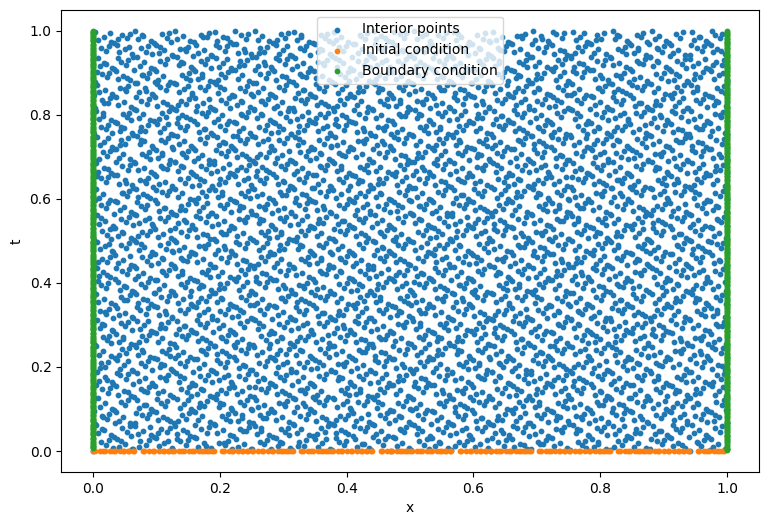

In [ ]:
torch.manual_seed(42)
nn_2phase = pinn_core.uniform_MLP(in_dim=2, out_dim=2,
                                  neurons=64, n_hidden_layers=8)
nn_2phase.apply(pinn_core.linear_init_xavier)
nn_2phase.to(device)

pinn_2phase = PiNN_2Phase_Thermal(nn_2phase,
                    domain=torch.tensor([[0., 1.], [0., 1.]]).to(device),
                    n_int=5000,
                    n_bound=[200, 400],
                    idx_bound=[(0,), (0, 1)],
                    bc_weight=[1., 1.],
                    device=device
                )

plt.figure(figsize=(9, 6))
plt.scatter(pinn_2phase.data_interior[:, 1].detach().cpu().numpy(),
            pinn_2phase.data_interior[:, 0].detach().cpu().numpy(),
            s=10, label="Interior points")
plt.scatter(pinn_2phase.data_boundary[0][0][:, 1].detach().cpu().numpy(),
            pinn_2phase.data_boundary[0][0][:, 0].detach().cpu().numpy(),
            s=10, label="Initial condition")
plt.scatter(np.r_[pinn_2phase.data_boundary[1][0][:, 1].detach().cpu().numpy(),
                  pinn_2phase.data_boundary[1][1][:, 1].detach().cpu().numpy()],
            np.r_[pinn_2phase.data_boundary[1][0][:, 0].detach().cpu().numpy(),
                  pinn_2phase.data_boundary[1][1][:, 0].detach().cpu().numpy()],
            s=10, label="Boundary condition")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

### Training

In [ ]:
n_epochs = 40
verbose_epochs = 10
optimizer = torch.optim.LBFGS(nn_2phase.parameters(),
                lr=0.5, max_iter=1000, max_eval=1500,
                history_size=150, line_search_fn="strong_wolfe",
                tolerance_change=1.*np.finfo(float).eps)
# optimizer = torch.optim.Adam(nn_burgers.parameters(), lr=8e-3, weight_decay=1e-5)

loss_hist = list()
loss_pde_hist = list()
loss_tb_hist = list()
loss_sb_hist = list()

def closure():
    optimizer.zero_grad()
    loss, loss_pde, loss_tb, loss_sb = pinn_2phase.compute_loss()
    loss.backward()

    loss_hist.append(loss.detach().cpu().item())
    loss_pde_hist.append(loss_pde.detach().cpu().item())
    loss_tb_hist.append(loss_tb.detach().cpu().item())
    loss_sb_hist.append(loss_sb.detach().cpu().item())
    return loss

epoch_split = [0]
for epoch in range(n_epochs):

    optimizer.step(closure=closure)

    if (epoch + 1) % verbose_epochs == 0:
        print("--------------- Epoch {:d} ---------------".format(epoch + 1))
        print("Average training loss = {:f}".format(np.array(loss_hist[epoch_split[-1]:]).mean()))
        epoch_split.append(len(loss_hist))

--------------- Epoch 10 ---------------
Average training loss = 0.645501
--------------- Epoch 20 ---------------
Average training loss = 0.445254
--------------- Epoch 30 ---------------
Average training loss = 0.445254
--------------- Epoch 40 ---------------
Average training loss = 0.445254


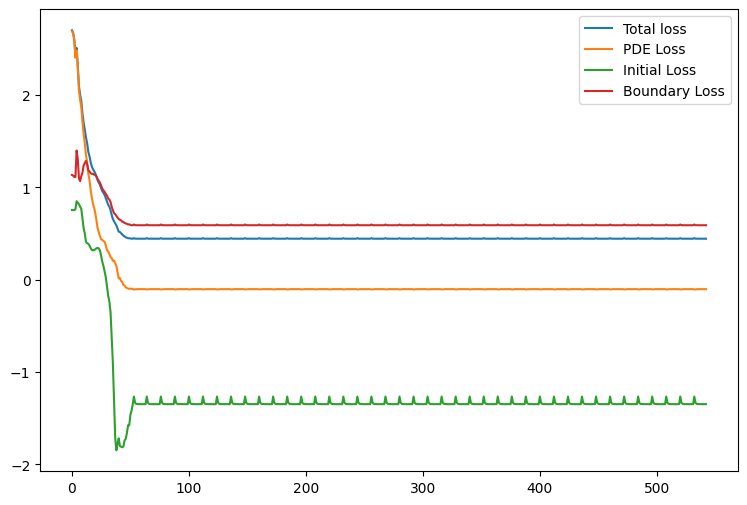

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(loss_hist, label="Total loss")
plt.plot(np.log10(np.asarray(loss_pde_hist)), label="PDE Loss")
plt.plot(np.log10(np.asarray(loss_tb_hist)), label="Initial Loss")
plt.plot(np.log10(np.asarray(loss_sb_hist)), label="Boundary Loss")
plt.legend()
plt.show()

### Validation

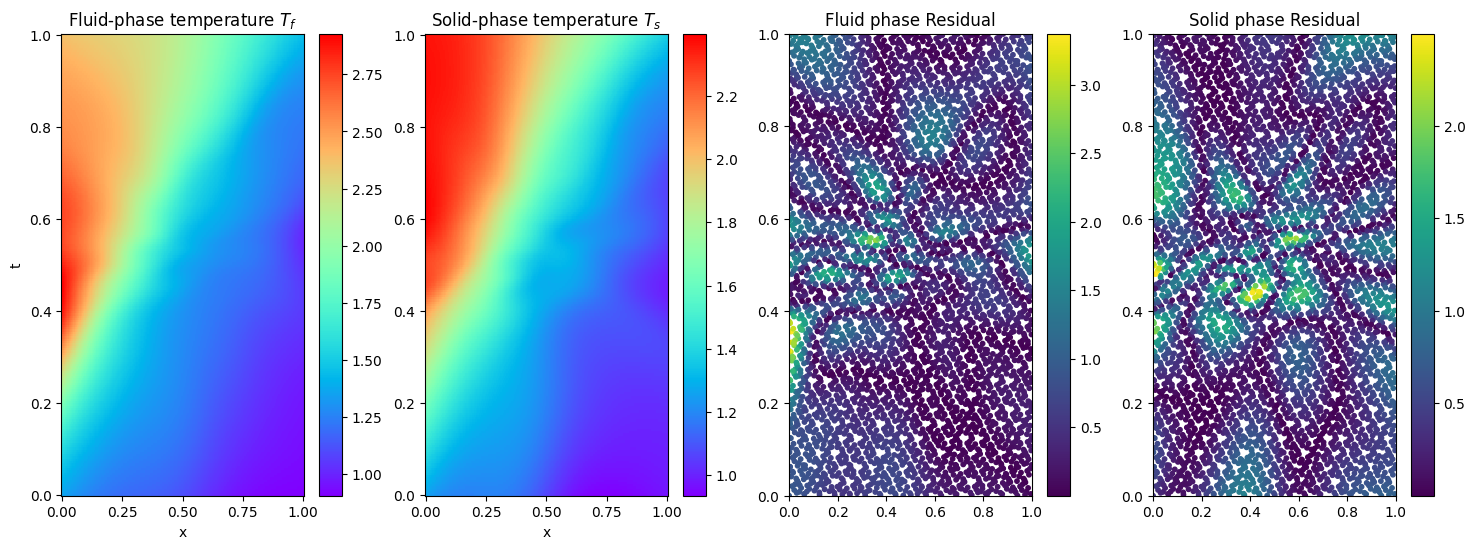

In [ ]:
nx_plot, nt_plot = 200, 200
x_mesh, t_mesh = torch.meshgrid(torch.linspace(0, 1, nx_plot), torch.linspace(0, 1., nt_plot), indexing='ij')
x_mesh = x_mesh.reshape(-1, )
t_mesh = t_mesh.reshape(-1, )
test_pred = pinn_2phase.forward(torch.stack((t_mesh, x_mesh), dim=1).to(device)).detach().cpu()
x_mesh = x_mesh.detach().reshape(nx_plot, nt_plot)
t_mesh = t_mesh.detach().reshape(nx_plot, nt_plot)
Tf_pred = test_pred[:, 0].reshape(nx_plot, nt_plot)
Ts_pred = test_pred[:, 1].reshape(nx_plot, nt_plot)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))
ax = axes[0]
im = ax.pcolormesh(x_mesh, t_mesh, Tf_pred, cmap="rainbow")
plt.colorbar(im, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_title("Fluid-phase temperature $T_f$")

ax = axes[1]
im = ax.pcolormesh(x_mesh, t_mesh, Ts_pred, cmap="rainbow")
plt.colorbar(im, ax=ax)
ax.set_xlabel("x")
ax.set_title("Solid-phase temperature $T_s$")

test_res = pinn_2phase.residual(pinn_2phase.data_interior)
ax = axes[2]
im = ax.scatter(pinn_2phase.data_interior[:, 1].detach().cpu().numpy(),
                 pinn_2phase.data_interior[:, 0].detach().cpu().numpy(),
                 s=10, c=np.abs(test_res[:, 0].detach().cpu().numpy()))
plt.colorbar(im, ax=ax)
ax.set_title("Fluid phase Residual")
ax.set_xlim([0., 1.])
ax.set_ylim([0., 1.])

ax = axes[3]
im = ax.scatter(pinn_2phase.data_interior[:, 1].detach().cpu().numpy(),
                 pinn_2phase.data_interior[:, 0].detach().cpu().numpy(),
                 s=10, c=np.abs(test_res[:, 1].detach().cpu().numpy()))
plt.colorbar(im, ax=ax)
ax.set_title("Solid phase Residual")
ax.set_xlim([0., 1.])
ax.set_ylim([0., 1.])

plt.show()

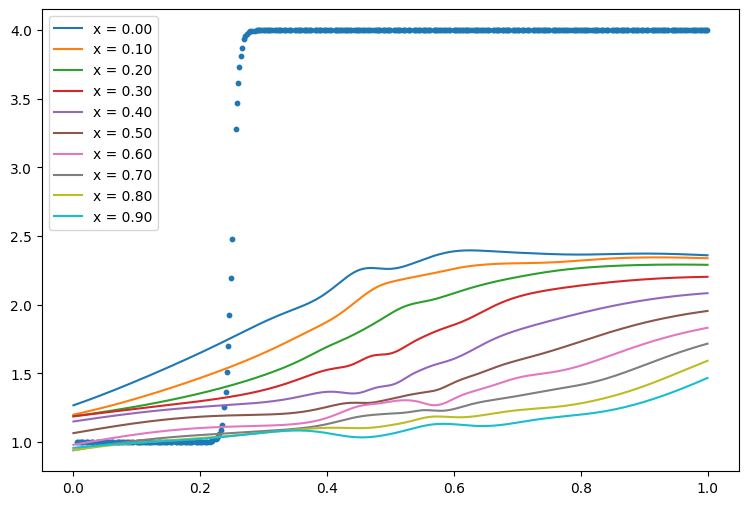

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(pinn_2phase.data_boundary[1][0][:, 0].detach().cpu(), pinn_2phase.bound[1][0][:, 0].detach().cpu(), s=10)
for i in range(0, 200, 20):
    plt.plot(t_mesh[i, :], Ts_pred[i, :], label="x = {:.2f}".format(x_mesh[i, 0]))
plt.legend()
plt.show()

## Thermal energy storage equation - separate networks

The same system, but approximated by separate networks.

In [ ]:
class PiNN_2Phase_Thermal_2Nets(pinn_core.PiNN_Cartesian):

    def __init__(self, forward_approx_f, forward_approx_s, loss_weights, *args,
                 diffuse_f=0.05, diffuse_s=0.08, couple_f=5., couple_s=6., background_flow=1., T0=1., Th=4.,
                 **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.approximator_f = forward_approx_f
        self.approximator_s = forward_approx_s
        self.wt = loss_weights
        self.diffuse_f = diffuse_f
        self.diffuse_s = diffuse_s
        self.couple_f = couple_f
        self.couple_s = couple_s
        self.U0 = background_flow
        self.bound_f, self.bound_s = self.boundary_condition(T0, Th)

    def boundary_condition(self, T0, Th):
        bound_f = [
            [T0*torch.ones(self.data_boundary[0][0].shape[0]).to(device), ],
            [T0 + (Th - T0)/(1. + torch.exp(-200.*(self.data_boundary[1][0][:, 0] - 0.25))),
             torch.zeros(self.data_boundary[1][1].shape[0]).to(device)]
        ]
        bound_s = [
            [T0*torch.ones(self.data_boundary[0][0].shape[0]).to(device),],
            [torch.zeros(self.data_boundary[1][0].shape[0]).to(device),
             torch.zeros(self.data_boundary[1][1].shape[0]).to(device)]
        ]
        return bound_f, bound_s

    def forward(self, x_input):
        return 3.*self.approximator_f(self.normalize(x_input)) + 1., 3.*self.approximator_s(self.normalize(x_input)) + 1.

    def residual(self, x_int):
        x_int.requires_grad = True
        Tf, Ts = self.forward(x_input=x_int)

        grad_Tf = torch.autograd.grad(Tf.sum(), x_int, create_graph=True)[0]
        dTf_dt = grad_Tf[:, 0]
        dTf_dx = grad_Tf[:, 1]
        d2Tf_dx2 = torch.autograd.grad(dTf_dx.sum(), x_int, create_graph=True)[0][:, 1]

        grad_Ts = torch.autograd.grad(Ts.sum(), x_int, create_graph=True)[0]
        dTs_dt = grad_Ts[:, 0]
        dTs_dx = grad_Ts[:, 1]
        d2Ts_dx2 = torch.autograd.grad(dTs_dx.sum(), x_int, create_graph=True)[0][:, 1]

        res_Tf = dTf_dt + self.U0*dTf_dx - self.diffuse_f*d2Tf_dx2 + self.couple_f*(Tf - Ts).squeeze()
        res_Ts = dTs_dt - self.diffuse_s*d2Ts_dx2 - self.couple_s*(Tf - Ts).squeeze()

        return res_Tf, res_Ts

    def boundary_loss(self):

        Tf_init, Ts_init = self.forward(self.data_boundary[0][0])
        loss_Tf_init = torch.mean(torch.abs(Tf_init.squeeze() - self.bound_f[0][0])**2)
        loss_Ts_init = torch.mean(torch.abs(Ts_init.squeeze() - self.bound_s[0][0])**2)

        self.data_boundary[1][0].requires_grad = True
        Tf_lbound, Ts_lbound = self.forward(self.data_boundary[1][0])
        dTs_dx_l = torch.autograd.grad(Ts_lbound.sum(), self.data_boundary[1][0], create_graph=True)[0][:, 1]
        loss_Tf_left = torch.mean(torch.abs(Tf_lbound.squeeze() - self.bound_f[1][0])**2)
        loss_Ts_left = torch.mean(torch.abs(dTs_dx_l - self.bound_s[1][0])**2)

        self.data_boundary[1][1].requires_grad = True
        Tf_rbound, Ts_rbound = self.forward(self.data_boundary[1][1])
        dTf_dx_r = torch.autograd.grad(Tf_rbound.sum(), self.data_boundary[1][1], create_graph=True)[0][:, 1]
        dTs_dx_r = torch.autograd.grad(Ts_rbound.sum(), self.data_boundary[1][1], create_graph=True)[0][:, 1]
        loss_Tf_right = torch.mean(torch.abs(dTf_dx_r - self.bound_f[1][1])**2)
        loss_Ts_right = torch.mean(torch.abs(dTs_dx_r - self.bound_s[1][1])**2)

        loss_bound_Tf = [[loss_Tf_init, ], [loss_Tf_left, loss_Tf_right]]
        loss_bound_Ts = [[loss_Ts_init, ], [loss_Ts_left, loss_Ts_right]]

        return loss_bound_Tf, loss_bound_Ts

    def compute_loss(self):
        res_pde = self.residual(self.data_interior)
        loss_Tf_pde, loss_Ts_pde = torch.mean(torch.abs(res_pde[0])**3), torch.mean(torch.abs(res_pde[1])**3)
        loss_Tf_bound, loss_Ts_bound = self.boundary_loss()
        loss = torch.log10(self.wt[0][-1]*loss_Tf_pde
                           + self.wt[0][0][0]*loss_Tf_bound[0][0]
                           + self.wt[0][1][0]*loss_Tf_bound[1][0]
                           + self.wt[0][1][1]*loss_Tf_bound[1][1]
                           + self.wt[1][-1]*loss_Ts_pde
                           + self.wt[1][0][0]*loss_Ts_bound[0][0]
                           + self.wt[1][1][0]*loss_Ts_bound[1][0]
                           + self.wt[1][1][1]*loss_Ts_bound[1][1])
        return loss, loss_Tf_pde, loss_Ts_pde, loss_Tf_bound, loss_Ts_bound

### The neural network

- Multilayer perceptron (fully-connected network)
- 32 neurons, 2 hidden layers
- 1024 interior sampling points, 128 sampling points for all boundaries
- Double-sided spacial boundary condition
- Single-sided temporal boundary condition (initial condition)

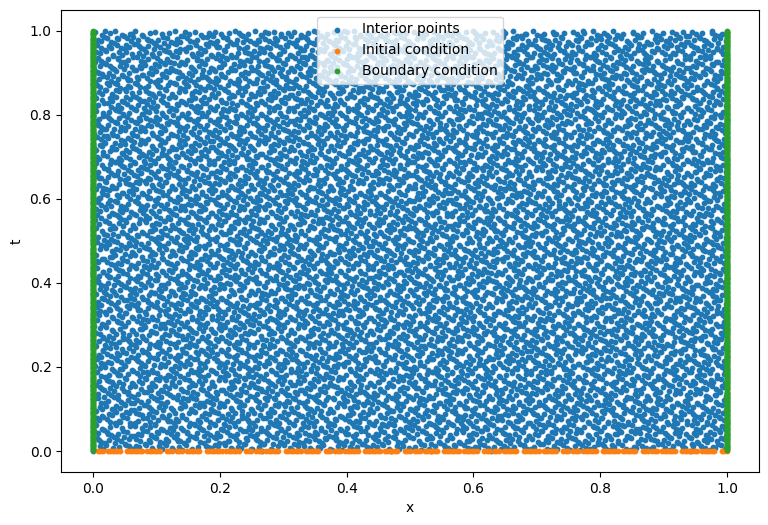

In [ ]:
torch.manual_seed(42)
# Fluid phase network
nn_phase_f = pinn_core.uniform_MLP(in_dim=2, out_dim=1,
                                   neurons=32, n_hidden_layers=3)
nn_phase_f.apply(pinn_core.linear_init_xavier)
nn_phase_f.to(device)
# Solid phase network
nn_phase_s = pinn_core.uniform_MLP(in_dim=2, out_dim=1,
                                   neurons=32, n_hidden_layers=3)
nn_phase_s.apply(pinn_core.linear_init_xavier)
nn_phase_s.to(device)

pinn_2phase = PiNN_2Phase_Thermal_2Nets(nn_phase_f, nn_phase_s,
                    loss_weights=[
                        # [[1.e+1,], [3.e-1, 1.e-2], 1.],
                        [[1.,], [1., 1.], 1.],
                        # [[1.e+1,], [1.e-3, 1.], 1.]
                        [[1.,], [1., 1.], 1.]
                    ],
                    domain=torch.tensor([[0., 1.], [0., 1.]]).to(device),
                    n_int=10000,
                    n_bound=[200, 500],
                    idx_bound=[(0,), (0, 1)],
                    bc_weight=[10., 1e-4],
                    couple_f=5.,
                    couple_s=6.,
                    device=device
                )

plt.figure(figsize=(9, 6))
plt.scatter(pinn_2phase.data_interior[:, 1].detach().cpu().numpy(),
            pinn_2phase.data_interior[:, 0].detach().cpu().numpy(),
            s=10, label="Interior points")
plt.scatter(pinn_2phase.data_boundary[0][0][:, 1].detach().cpu().numpy(),
            pinn_2phase.data_boundary[0][0][:, 0].detach().cpu().numpy(),
            s=10, label="Initial condition")
plt.scatter(np.r_[pinn_2phase.data_boundary[1][0][:, 1].detach().cpu().numpy(),
                  pinn_2phase.data_boundary[1][1][:, 1].detach().cpu().numpy()],
            np.r_[pinn_2phase.data_boundary[1][0][:, 0].detach().cpu().numpy(),
                  pinn_2phase.data_boundary[1][1][:, 0].detach().cpu().numpy()],
            s=10, label="Boundary condition")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

### Training

In [ ]:
n_epochs_pre = 2000
verbose_epochs_pre = 100
n_epochs = 20
verbose_epochs = 1

optimizer_pre = torch.optim.Adam(list(nn_phase_f.parameters()) + list(nn_phase_s.parameters()),
                                 lr=1e-3, weight_decay=3.e-5)
optimizer = torch.optim.LBFGS(list(nn_phase_f.parameters()) + list(nn_phase_s.parameters()),
                lr=1.0, max_iter=1000, max_eval=1500,
                history_size=150, line_search_fn="strong_wolfe",
                tolerance_change=1.*np.finfo(float).eps)
# optimizer = torch.optim.Adam(list(nn_phase_f.parameters()) + list(nn_phase_s.parameters()), lr=1e-3, weight_decay=0.)

hist_loss = list()
hist_Tf_pde = list()
hist_Tf_init = list()
hist_Tf_left = list()
hist_Tf_right = list()
hist_Ts_pde = list()
hist_Ts_init = list()
hist_Ts_left = list()
hist_Ts_right = list()

def closure():
    optimizer.zero_grad()
    loss, loss_Tf_pde, loss_Ts_pde, loss_Tf_bound, loss_Ts_bound = pinn_2phase.compute_loss()
    loss.backward()

    hist_loss.append(loss.detach().cpu().item())
    hist_Tf_pde.append(loss_Tf_pde.detach().cpu().item())
    hist_Tf_init.append(loss_Tf_bound[0][0].detach().cpu().item())
    hist_Tf_left.append(loss_Tf_bound[1][0].detach().cpu().item())
    hist_Tf_right.append(loss_Tf_bound[1][1].detach().cpu().item())
    hist_Ts_pde.append(loss_Ts_pde.detach().cpu().item())
    hist_Ts_init.append(loss_Ts_bound[0][0].detach().cpu().item())
    hist_Ts_left.append(loss_Ts_bound[1][0].detach().cpu().item())
    hist_Ts_right.append(loss_Ts_bound[1][1].detach().cpu().item())
    return loss

print("Gradient-based pre-training...")

epoch_split = [0]
for epoch in range(n_epochs_pre):
    optimizer_pre.step(closure=closure)
    if (epoch + 1) % verbose_epochs_pre == 0:
        print("--------------- Epoch {:d} ---------------".format(epoch + 1))
        print("Average training loss = {:f}".format(np.array(hist_loss[epoch_split[-1]:]).mean()))
        epoch_split.append(len(hist_loss))

print("L-BFGS training...")
# pinn_2phase.wt[0][1][0] *= 0.3
# pinn_2phase.wt[1][1][0] *= 0.3

for epoch in range(n_epochs):

    optimizer.step(closure=closure)
    pinn_2phase.wt[0][1][0] *= 1.1
    # pinn_2phase.wt[1][1][0] *= 1.05

    if (epoch + 1) % verbose_epochs == 0:
        print("--------------- Epoch {:d} ---------------".format(epoch + 1))
        print("Average training loss = {:f}".format(np.array(hist_loss[epoch_split[-1]:]).mean()))
        epoch_split.append(len(hist_loss))


Gradient-based pre-training...
--------------- Epoch 100 ---------------
Average training loss = 1.239774
--------------- Epoch 200 ---------------
Average training loss = 0.405539
--------------- Epoch 300 ---------------
Average training loss = 0.265056
--------------- Epoch 400 ---------------
Average training loss = 0.193313
--------------- Epoch 500 ---------------
Average training loss = 0.086878
--------------- Epoch 600 ---------------
Average training loss = 0.042793
--------------- Epoch 700 ---------------
Average training loss = -0.034772
--------------- Epoch 800 ---------------
Average training loss = -0.090930
--------------- Epoch 900 ---------------
Average training loss = -0.162866
--------------- Epoch 1000 ---------------
Average training loss = 0.146848
--------------- Epoch 1100 ---------------
Average training loss = 0.552885
--------------- Epoch 1200 ---------------
Average training loss = 0.260678
--------------- Epoch 1300 ---------------
Average training los

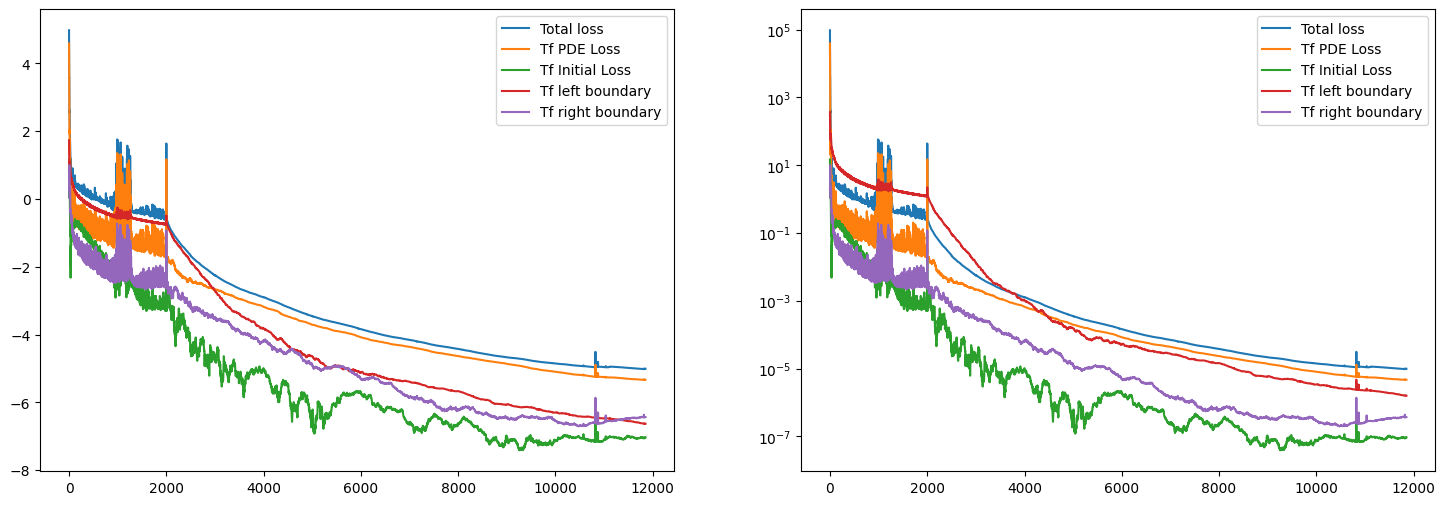

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

ax = axes[0]
ax.plot(hist_loss, label="Total loss")
ax.plot(np.log10(np.asarray(hist_Tf_pde)), label="Tf PDE Loss")
ax.plot(np.log10(np.asarray(hist_Tf_init)), label="Tf Initial Loss")
ax.plot(np.log10(np.asarray(hist_Tf_left)), label="Tf left boundary")
ax.plot(np.log10(np.asarray(hist_Tf_right)), label="Tf right boundary")
# ax.plot(np.log10(np.asarray(hist_Ts_pde)), label="Ts PDE Loss")
# ax.plot(np.log10(np.asarray(hist_Ts_init)), label="Ts Initial Loss")
# ax.plot(np.log10(np.asarray(hist_Ts_left)), label="Ts left boundary")
# ax.plot(np.log10(np.asarray(hist_Ts_right)), label="Ts right boundary")
ax.legend()

ax = axes[1]
ax.semilogy(np.power(10, np.asarray(hist_loss)), label="Total loss")
ax.semilogy(pinn_2phase.wt[0][-1]*np.asarray(hist_Tf_pde), label="Tf PDE Loss")
ax.semilogy(pinn_2phase.wt[0][0][0]*np.asarray(hist_Tf_init), label="Tf Initial Loss")
ax.semilogy(pinn_2phase.wt[0][1][0]*np.asarray(hist_Tf_left), label="Tf left boundary")
ax.semilogy(pinn_2phase.wt[0][1][1]*np.asarray(hist_Tf_right), label="Tf right boundary")
# ax.semilogy(pinn_2phase.wt[1][-1]*np.asarray(hist_Ts_pde), label="Ts PDE Loss")
# ax.semilogy(pinn_2phase.wt[1][0][0]*np.asarray(hist_Ts_init), label="Ts Initial Loss")
# ax.semilogy(pinn_2phase.wt[1][1][0]*np.asarray(hist_Ts_left), label="Ts left boundary")
# ax.semilogy(pinn_2phase.wt[1][1][1]*np.asarray(hist_Ts_right), label="Ts right boundary")
ax.legend()

plt.show()

In [ ]:
# torch.save(nn_phase_f.state_dict(), "./drive/MyDrive/nb_outputs/net_phase_f.pth")
# torch.save(nn_phase_s.state_dict(), "./drive/MyDrive/nb_outputs/net_phase_s.pth")

nn_state = torch.load("./drive/MyDrive/nb_outputs/net_phase_f.pth")
nn_state

### Validation

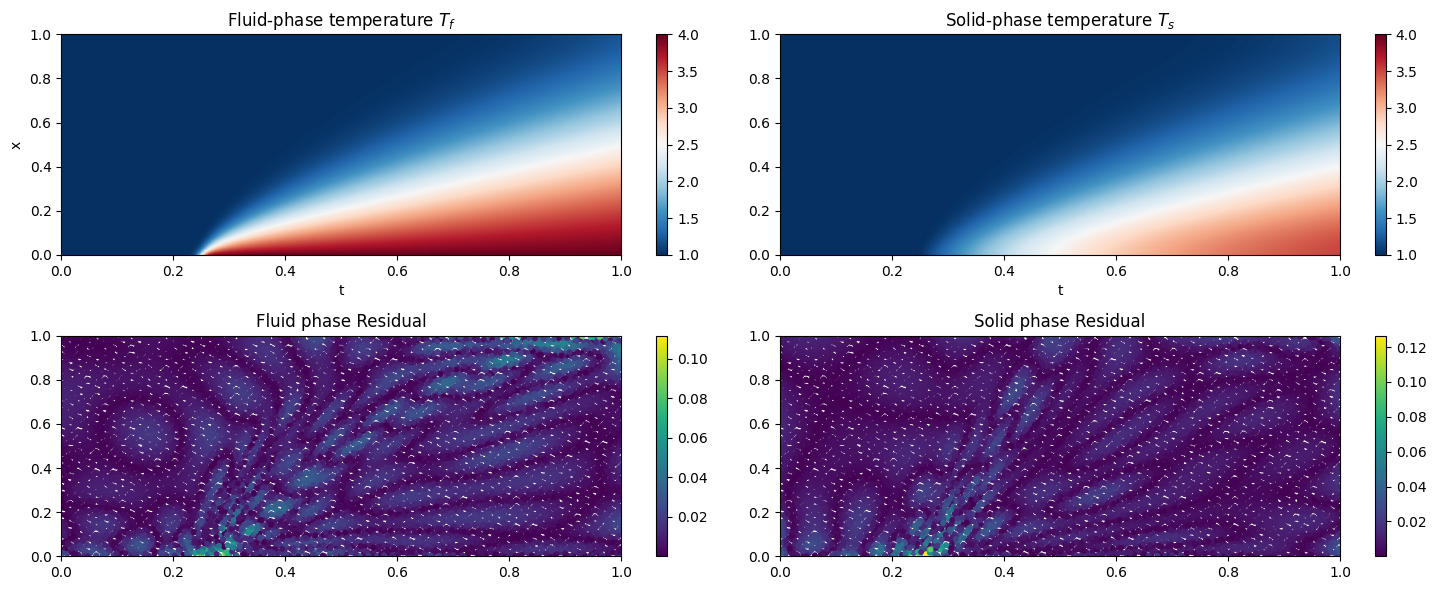

In [ ]:
nx_plot, nt_plot = 200, 400
x_mesh, t_mesh = torch.meshgrid(torch.linspace(0., 1, nx_plot), torch.linspace(0, 1., nt_plot), indexing='ij')
x_mesh = x_mesh.reshape(-1, )
t_mesh = t_mesh.reshape(-1, )
pt_eval = torch.stack((t_mesh, x_mesh), dim=1).to(device)
pt_eval.requires_grad = True
Tf_pred, Ts_pred = pinn_2phase.forward(pt_eval)
dTf_dx_pred = torch.autograd.grad(Tf_pred.sum(), pt_eval)[0][:, 1]
dTs_dx_pred = torch.autograd.grad(Ts_pred.sum(), pt_eval)[0][:, 1]
x_mesh = x_mesh.detach().reshape(nx_plot, nt_plot)
t_mesh = t_mesh.detach().reshape(nx_plot, nt_plot)
Tf_pred = Tf_pred.detach().cpu().reshape(nx_plot, nt_plot)
Ts_pred = Ts_pred.detach().cpu().reshape(nx_plot, nt_plot)
dTf_dx_pred = dTf_dx_pred.detach().cpu().reshape(nx_plot, nt_plot)
dTs_dx_pred = dTs_dx_pred.detach().cpu().reshape(nx_plot, nt_plot)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
ax = axes[0][0]
im = ax.pcolormesh(t_mesh, x_mesh, Tf_pred, cmap="RdBu_r", shading="gouraud")
plt.colorbar(im, ax=ax)
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_title("Fluid-phase temperature $T_f$")

ax = axes[0][1]
im = ax.pcolormesh(t_mesh, x_mesh, Ts_pred, cmap="RdBu_r", clim=[1., 4.], shading="gouraud")
plt.colorbar(im, ax=ax)
ax.set_xlabel("t")
ax.set_title("Solid-phase temperature $T_s$")

Tf_res, Ts_res = pinn_2phase.residual(pinn_2phase.data_interior)
ax = axes[1][0]
im = ax.scatter(pinn_2phase.data_interior[:, 0].detach().cpu().numpy(),
                pinn_2phase.data_interior[:, 1].detach().cpu().numpy(),
                s=10, c=np.abs(Tf_res.detach().cpu().numpy()))
plt.colorbar(im, ax=ax)
ax.set_title("Fluid phase Residual")
ax.set_xlim([0., 1.])
ax.set_ylim([0., 1.])

ax = axes[1][1]
im = ax.scatter(pinn_2phase.data_interior[:, 0].detach().cpu().numpy(),
                pinn_2phase.data_interior[:, 1].detach().cpu().numpy(),
                s=10, c=np.abs(Ts_res.detach().cpu().numpy()))
plt.colorbar(im, ax=ax)
ax.set_title("Solid phase Residual")
ax.set_xlim([0., 1.])
ax.set_ylim([0., 1.])

plt.tight_layout()
plt.show()

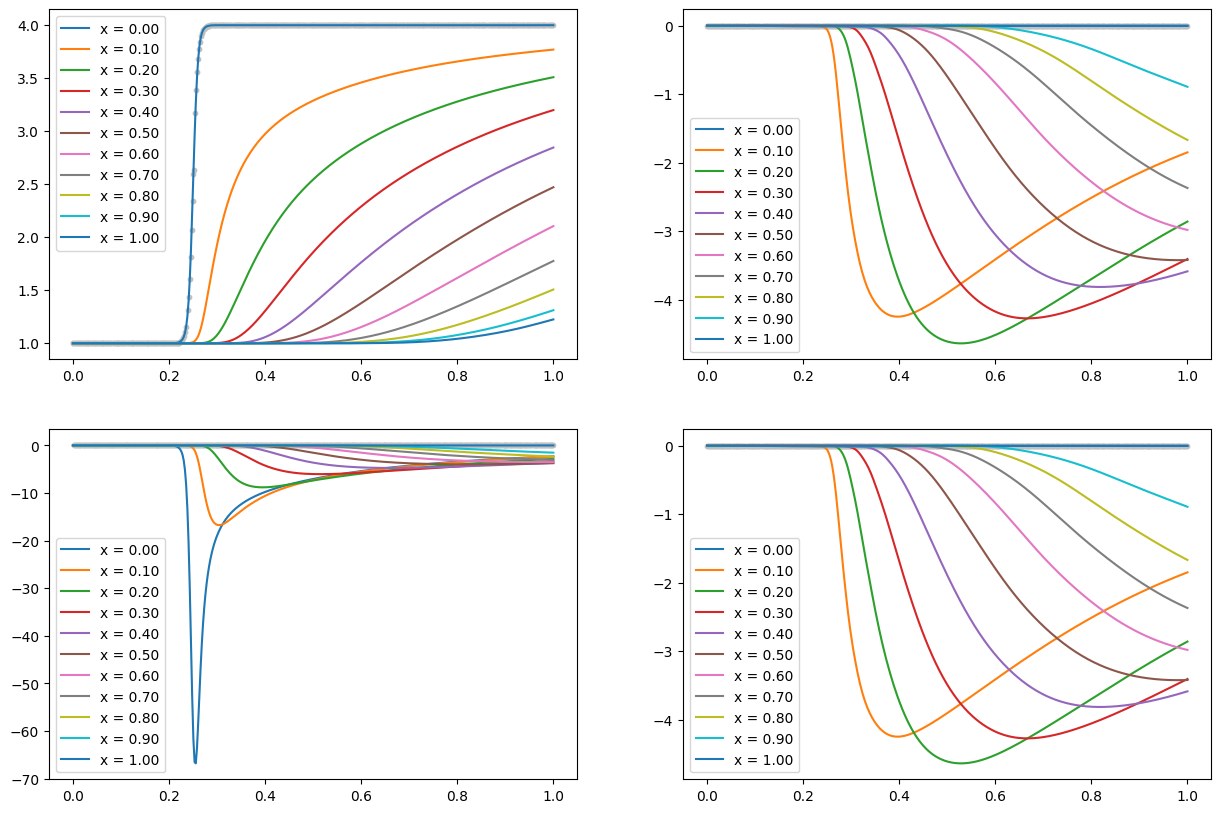

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

ax = axes[0][0]
ax.scatter(pinn_2phase.data_boundary[1][0][:, 0].detach().cpu(), pinn_2phase.bound_f[1][0].detach().cpu(), s=10, color="silver")
for i in range(0, 200, 20):
    ax.plot(t_mesh[i, :], Tf_pred[i, :], label="x = {:.2f}".format(x_mesh[i, 0]))
ax.plot(t_mesh[-1, :], Tf_pred[-1, :], label="x = {:.2f}".format(x_mesh[-1, 0]))
ax.legend()

ax = axes[1][0]
ax.scatter(pinn_2phase.data_boundary[1][1][:, 0].detach().cpu(), pinn_2phase.bound_f[1][1].detach().cpu(), s=10, color="silver")
for i in range(0, 200, 20):
    ax.plot(t_mesh[i, :], dTf_dx_pred[i, :], label="x = {:.2f}".format(x_mesh[i, 0]))
ax.plot(t_mesh[-1, :], dTf_dx_pred[-1, :], label="x = {:.2f}".format(x_mesh[-1, 0]))
ax.legend()

ax = axes[0][1]
ax.scatter(pinn_2phase.data_boundary[1][0][:, 0].detach().cpu(), pinn_2phase.bound_s[1][0].detach().cpu(), s=10, color="silver")
for i in range(0, 200, 20):
    ax.plot(t_mesh[i, :], dTs_dx_pred[i, :], label="x = {:.2f}".format(x_mesh[i, 0]))
ax.plot(t_mesh[-1, :], dTs_dx_pred[-1, :], label="x = {:.2f}".format(x_mesh[-1, 0]))
ax.legend()

ax = axes[1][1]
ax.scatter(pinn_2phase.data_boundary[1][0][:, 0].detach().cpu(), pinn_2phase.bound_s[1][1].detach().cpu(), s=10, color="silver")
for i in range(0, 200, 20):
    ax.plot(t_mesh[i, :], dTs_dx_pred[i, :], label="x = {:.2f}".format(x_mesh[i, 0]))
ax.plot(t_mesh[-1, :], dTs_dx_pred[-1, :], label="x = {:.2f}".format(x_mesh[-1, 0]))
ax.legend()

plt.show()

### Prediction

In [ ]:
nn_phase_f.load_state_dict(torch.load("./drive/MyDrive/Colab Notebooks/two-phase_thermal/net_phase_f.pth"))
nn_phase_s.load_state_dict(torch.load("./drive/MyDrive/Colab Notebooks/two-phase_thermal/net_phase_s.pth"))
nn_phase_f.to(device)
nn_phase_s.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): Tanh()
  (8): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
import pandas as pd

test_ds = pd.read_csv("./drive/MyDrive/Colab Notebooks/two-phase_thermal/Task1/TestingData.txt", header=0)
test_ds

t      x
0      0.624062  0.895
1      0.783512  0.778
2      0.398106  0.469
3      0.415906  0.948
4      0.949750  0.457
...         ...    ...
99995  0.811444  0.697
99996  0.498512  0.248
99997  0.718912  0.100
99998  0.953963  0.247
99999  0.463612  0.740

[100000 rows x 2 columns]

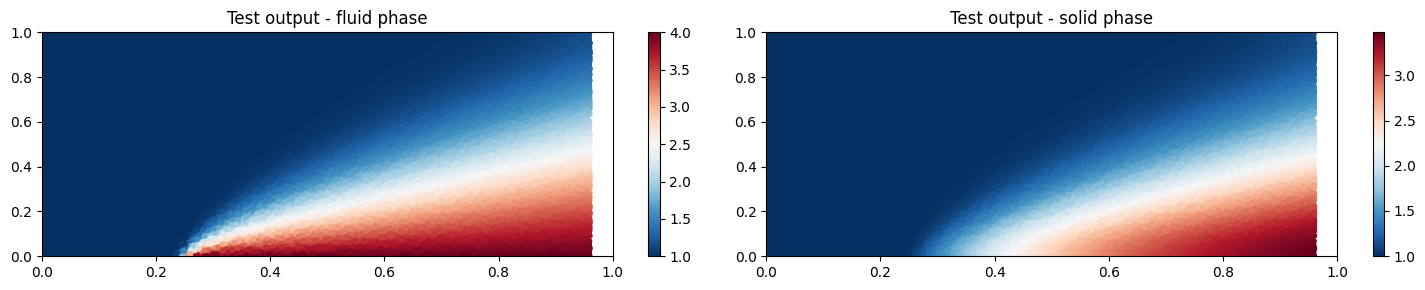

t      x        tf        ts
0      0.624062  0.895  1.005725  1.002342
1      0.783512  0.778  1.185951  1.107969
2      0.398106  0.469  1.012978  1.005573
3      0.415906  0.948  0.999665  0.999771
4      0.949750  0.457  2.536717  2.191473
...         ...    ...       ...       ...
99995  0.811444  0.697  1.385628  1.239575
99996  0.498512  0.248  2.200176  1.653037
99997  0.718912  0.100  3.594660  2.984364
99998  0.953963  0.247  3.319475  2.957029
99999  0.463612  0.740  1.000064  0.999515

[100000 rows x 4 columns]

In [ ]:
test_tensor = torch.from_numpy(test_ds.to_numpy()).to(torch.float32).to(device)
test_output_f, test_output_s = pinn_2phase.forward(test_tensor)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
ax = axes[0]
im = ax.scatter(test_tensor[:, 0].detach().cpu().numpy(),
                test_tensor[:, 1].detach().cpu().numpy(),
                s=10, c=np.abs(test_output_f.detach().cpu().numpy()), cmap="RdBu_r")
plt.colorbar(im, ax=ax)
ax.set_title("Test output - fluid phase")
ax.set_xlim([0., 1.])
ax.set_ylim([0., 1.])

ax = axes[1]
im = ax.scatter(test_tensor[:, 0].detach().cpu().numpy(),
                test_tensor[:, 1].detach().cpu().numpy(),
                s=10, c=np.abs(test_output_s.detach().cpu().numpy()), cmap="RdBu_r")
plt.colorbar(im, ax=ax)
ax.set_title("Test output - solid phase")
ax.set_xlim([0., 1.])
ax.set_ylim([0., 1.])

plt.tight_layout()
plt.show()

test_ds["tf"] = test_output_f.detach().cpu().numpy()
test_ds["ts"] = test_output_s.detach().cpu().numpy()
test_ds

In [ ]:
test_ds.to_csv("./drive/MyDrive/Colab Notebooks/two-phase_thermal/Task1/Task1.txt", index=False)

## Thermal energy storage - solid temperature inversion

Given data on fluid temperature field, invert for solid-phase temperature.

First, inspect the observed data.

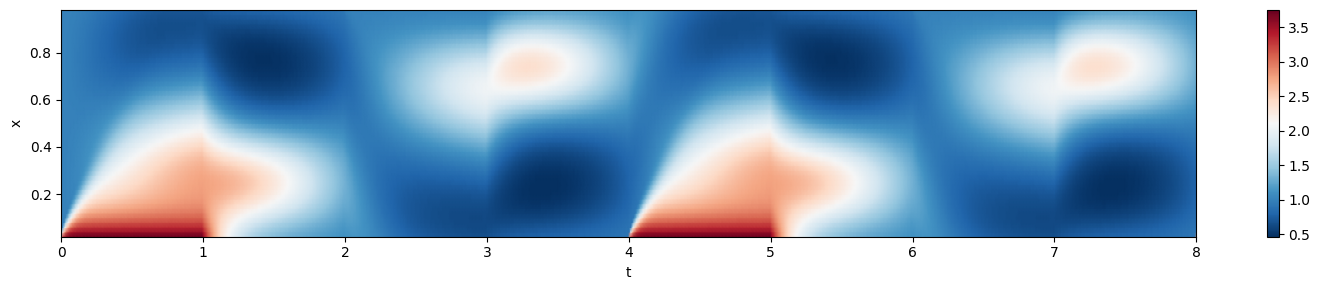

In [4]:
data_train = pd.read_csv("./drive/MyDrive/Colab Notebooks/two-phase_thermal/Task2/DataSolution.txt", header=0)
train_input = torch.from_numpy(data_train.iloc[:, :2].to_numpy()).to(torch.float32).to(device)
train_output = torch.from_numpy(data_train["tf"].to_numpy()).to(torch.float32).to(device)

plt.figure(figsize=(15, 3))

# plt.scatter(train_input[:, 0].detach().cpu(), train_input[:, 1].detach().cpu(), s=10,
#             c=train_output.detach().cpu(), cmap="RdBu_r")
plt.pcolormesh(train_input[:, 0].detach().cpu().reshape(49, 800),
               train_input[:, 1].detach().cpu().reshape(49, 800),
               train_output.detach().cpu().reshape(49, 800), cmap="RdBu_r", shading="gouraud")
plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
# plt.xlim([0., 1.])
# plt.ylim([0., 0.3])

plt.tight_layout()
plt.show()

In [5]:
class PiNN_2Phase_Fluid(pinn_core.PiNN_Cartesian):

    def __init__(self, forward_approx_f, forward_approx_s, train_input, train_output, loss_weights, *args,
                 diffuse_f=0.005, couple_f=5., cycle=4., T0=1., Tc=1., Th=4., charge_flow=1., discharge_flow=-1.,
                 charge_range=(0., 1.), discharge_range=(2., 3.), smoothness_reg=0,
                 **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.approximator_f = forward_approx_f
        self.approximator_s = forward_approx_s
        self.wt = loss_weights
        self.train_i = train_input
        self.train_o = train_output
        self.diffuse_f = diffuse_f
        self.couple_f = couple_f
        self.cycle = cycle
        self.T0 = T0
        self.Tc = Tc
        self.Th = Th
        self.charge_flow = charge_flow
        self.charge_range = charge_range
        self.discharge_flow = discharge_flow
        self.discharge_range = discharge_range
        self.bound_f = self.boundary_condition(T0, Th)

    def get_background_flow(self, t):
        u0 = torch.zeros(t.shape, device=device)
        cycle_t = t - self.cycle*torch.floor(t/self.cycle)
        u0[(cycle_t >= self.charge_range[0]) & (cycle_t < self.charge_range[1])] = self.charge_flow
        u0[(cycle_t >= self.discharge_range[0]) & (cycle_t < self.discharge_range[1])] = self.discharge_flow
        return u0

    def get_left_bound(self, t):
        bound_left = torch.zeros(t.shape, device=device)
        cycle_t = t - self.cycle*torch.floor(t/self.cycle)
        bound_left[(cycle_t >= self.charge_range[0]) & (cycle_t < self.charge_range[1])] = self.Th
        return bound_left

    def get_right_bound(self, t):
        bound_right = torch.zeros(t.shape, device=device)
        cycle_t = t - self.cycle*torch.floor(t/self.cycle)
        bound_right[(cycle_t >= self.discharge_range[0]) & (cycle_t < self.discharge_range[1])] = self.Tc
        return bound_right

    def boundary_condition(self, T0, Th):
        bound_f = [
            [self.T0*torch.ones(self.data_boundary[0][0].shape[0]).to(device), ],
            [self.get_left_bound(self.data_boundary[1][0][:, 0]),
             self.get_right_bound(self.data_boundary[1][1][:, 0])]
        ]
        return bound_f

    def forward(self, x_input):
        return (self.Th - self.Tc)*self.approximator_f(self.normalize(x_input)) + self.Tc, \
            (self.Th - self.Tc)*self.approximator_s(self.normalize(x_input)) + self.Tc

    def residual(self, x_int):
        x_int.requires_grad = True
        Tf, Ts = self.forward(x_input=x_int)

        grad_Tf = torch.autograd.grad(Tf.sum(), x_int, create_graph=True)[0]
        dTf_dt = grad_Tf[:, 0]
        dTf_dx = grad_Tf[:, 1]
        d2Tf_dx2 = torch.autograd.grad(dTf_dx.sum(), x_int, create_graph=True)[0][:, 1]

        res_Tf = dTf_dt + self.get_background_flow(x_int[:, 0])*dTf_dx - self.diffuse_f*d2Tf_dx2 + self.couple_f*(Tf - Ts).squeeze()

        return res_Tf

    def misfit(self, x_obs, T_out):
        Tf, _ = self.forward(x_input=x_obs)
        return torch.mean(torch.abs(Tf.reshape(-1,) - T_out.reshape(-1,))**2)

    def complexity(self, x_int):
        _, Ts = self.forward(x_input=x_int)
        grad_Ts = torch.autograd.grad(Ts.sum(), x_int, create_graph=True)[0]
        return torch.mean(torch.abs(grad_Ts.reshape(-1,))**2)

    def boundary_loss(self):

        Tf_init, _ = self.forward(self.data_boundary[0][0])
        loss_Tf_init = torch.mean(torch.abs(Tf_init.squeeze() - self.bound_f[0][0])**2)

        self.data_boundary[1][0].requires_grad = True
        Tf_lbound, _ = self.forward(self.data_boundary[1][0])
        dTf_dx_l = torch.autograd.grad(Tf_lbound.sum(), self.data_boundary[1][0], create_graph=True)[0][:, 1]

        cycle_t = self.data_boundary[1][0][:, 0] - self.cycle*torch.floor(self.data_boundary[1][0][:, 0]/self.cycle)
        idx_charge = (cycle_t >= self.charge_range[0]) & (cycle_t < self.charge_range[1])

        res_left = torch.cat([Tf_lbound[idx_charge, 0] - self.bound_f[1][0][idx_charge],
                            #   Tf_lbound[~idx_charge, 0] - self.bound_f[1][0][~idx_charge]])
                              dTf_dx_l[~idx_charge] - self.bound_f[1][0][~idx_charge]])
        loss_Tf_left = torch.mean(torch.abs(res_left)**2)

        self.data_boundary[1][1].requires_grad = True
        Tf_rbound, _ = self.forward(self.data_boundary[1][1])
        dTf_dx_r = torch.autograd.grad(Tf_rbound.sum(), self.data_boundary[1][1], create_graph=True)[0][:, 1]

        cycle_t = self.data_boundary[1][1][:, 0] - self.cycle*torch.floor(self.data_boundary[1][1][:, 0]/self.cycle)
        idx_discharge = (cycle_t >= self.discharge_range[0]) & (cycle_t < self.discharge_range[1])

        res_right = torch.cat([Tf_rbound[idx_discharge, 0] - self.bound_f[1][1][idx_discharge],
                            #    Tf_rbound[~idx_discharge, 0] - self.bound_f[1][1][~idx_discharge]])
                               dTf_dx_r[~idx_discharge] - self.bound_f[1][1][~idx_discharge]])
        loss_Tf_right = torch.mean(torch.abs(res_right)**2)

        loss_bound_Tf = [[loss_Tf_init, ], [loss_Tf_left, loss_Tf_right]]

        return loss_bound_Tf

    def compute_loss(self):
        res_pde = self.residual(self.data_interior)
        loss_Tf_pde = torch.mean(torch.abs(res_pde)**3)
        loss_Tf_bound = self.boundary_loss()
        loss_train = self.misfit(self.train_i, self.train_o)
        # loss_train = torch.tensor([0])
        loss = torch.log10(loss_train
                           + self.wt[-1]*loss_Tf_pde
                           + self.wt[0][0]*loss_Tf_bound[0][0]
                           + self.wt[1][0]*loss_Tf_bound[1][0]
                           + self.wt[1][1]*loss_Tf_bound[1][1]
                           )
        return loss, loss_train, loss_Tf_pde, loss_Tf_bound

### The neural network

- Multilayer perceptron (fully-connected network)
- 32 neurons, 2 hidden layers
- 1024 interior sampling points, 128 sampling points for all boundaries
- Double-sided spacial boundary condition
- Single-sided temporal boundary condition (initial condition)

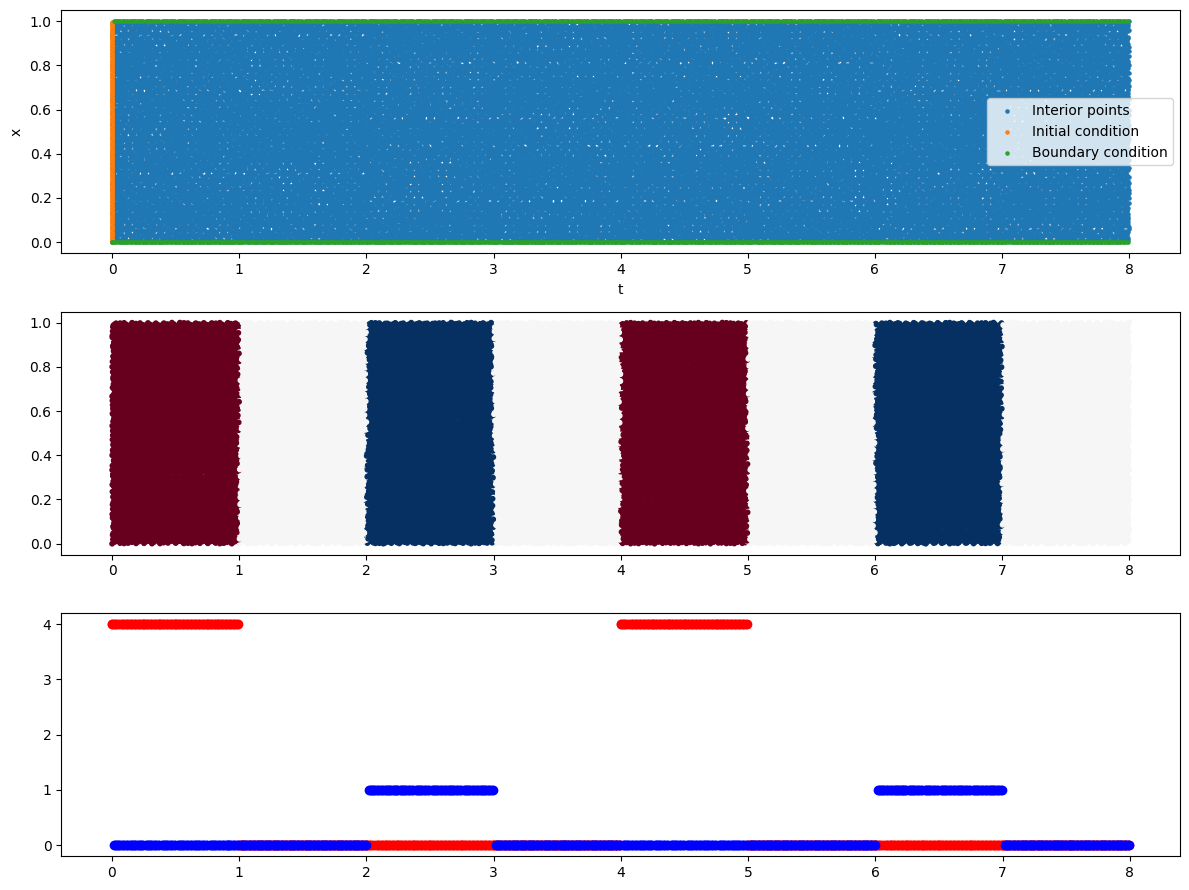

In [6]:
torch.manual_seed(42)
# Fluid phase network
nn_phase_f = pinn_core.uniform_MLP(in_dim=2, out_dim=1,
                                   neurons=32, n_hidden_layers=3)
nn_phase_f.apply(pinn_core.linear_init_xavier)
nn_phase_f.to(device)
# Solid phase network
nn_phase_s = pinn_core.uniform_MLP(in_dim=2, out_dim=1,
                                   neurons=32, n_hidden_layers=3)
nn_phase_s.apply(pinn_core.linear_init_xavier)
nn_phase_s.to(device)

trange = [0., 8.]
xrange = [0., 1.]

pinn_2phase = PiNN_2Phase_Fluid(nn_phase_f, nn_phase_s,
                    train_input[train_input[:, 0] < trange[-1], :], train_output[train_input[:, 0] < trange[-1]],
                    loss_weights=[[1.,], [1., 1.], 1.],
                    domain=torch.tensor([trange, xrange]).to(device),
                    n_int=40000,
                    n_bound=[200, 800],
                    idx_bound=[(0,), (0, 1)],
                    bc_weight=[10., 1e-4],
                    # couple_f=0.,
                    device=device
                )

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))

ax = axes[0]
ax.scatter(pinn_2phase.data_interior[:, 0].detach().cpu().numpy(),
           pinn_2phase.data_interior[:, 1].detach().cpu().numpy(),
           s=5, label="Interior points")
ax.scatter(pinn_2phase.data_boundary[0][0][:, 0].detach().cpu().numpy(),
           pinn_2phase.data_boundary[0][0][:, 1].detach().cpu().numpy(),
           s=5, label="Initial condition")
ax.scatter(np.r_[pinn_2phase.data_boundary[1][0][:, 0].detach().cpu().numpy(),
                 pinn_2phase.data_boundary[1][1][:, 0].detach().cpu().numpy()],
           np.r_[pinn_2phase.data_boundary[1][0][:, 1].detach().cpu().numpy(),
                 pinn_2phase.data_boundary[1][1][:, 1].detach().cpu().numpy()],
            s=5, label="Boundary condition")
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.legend()

ax = axes[1]
im = ax.scatter(pinn_2phase.data_interior[:, 0].detach().cpu().numpy(),
                pinn_2phase.data_interior[:, 1].detach().cpu().numpy(),
                s=10, c=pinn_2phase.get_background_flow(pinn_2phase.data_interior[:, 0]).detach().cpu(), cmap="RdBu_r")
# plt.colorbar(im, ax=ax)

ax = axes[2]
ax.scatter(pinn_2phase.data_boundary[1][0][:, 0].detach().cpu(),
           pinn_2phase.bound_f[1][0].detach().cpu(), color='r', label="Upper boundary")
ax.scatter(pinn_2phase.data_boundary[1][1][:, 0].detach().cpu(),
           pinn_2phase.bound_f[1][1].detach().cpu(), color='b', label="Lower boundary")

plt.tight_layout()
plt.show()

Alternatively, split the domain into different regions

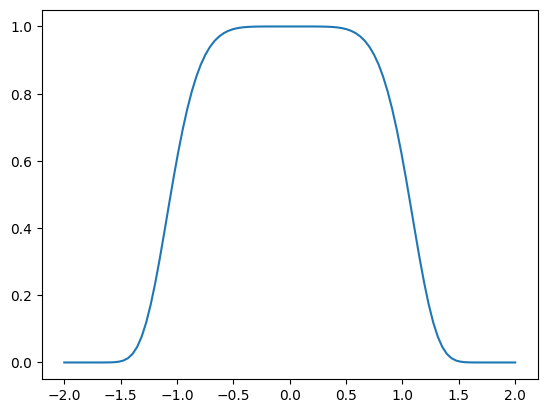

In [ ]:
t = torch.linspace(-2, 2, 100)
y = torch.exp(-(t/1)**6/2)

plt.plot(t, y)

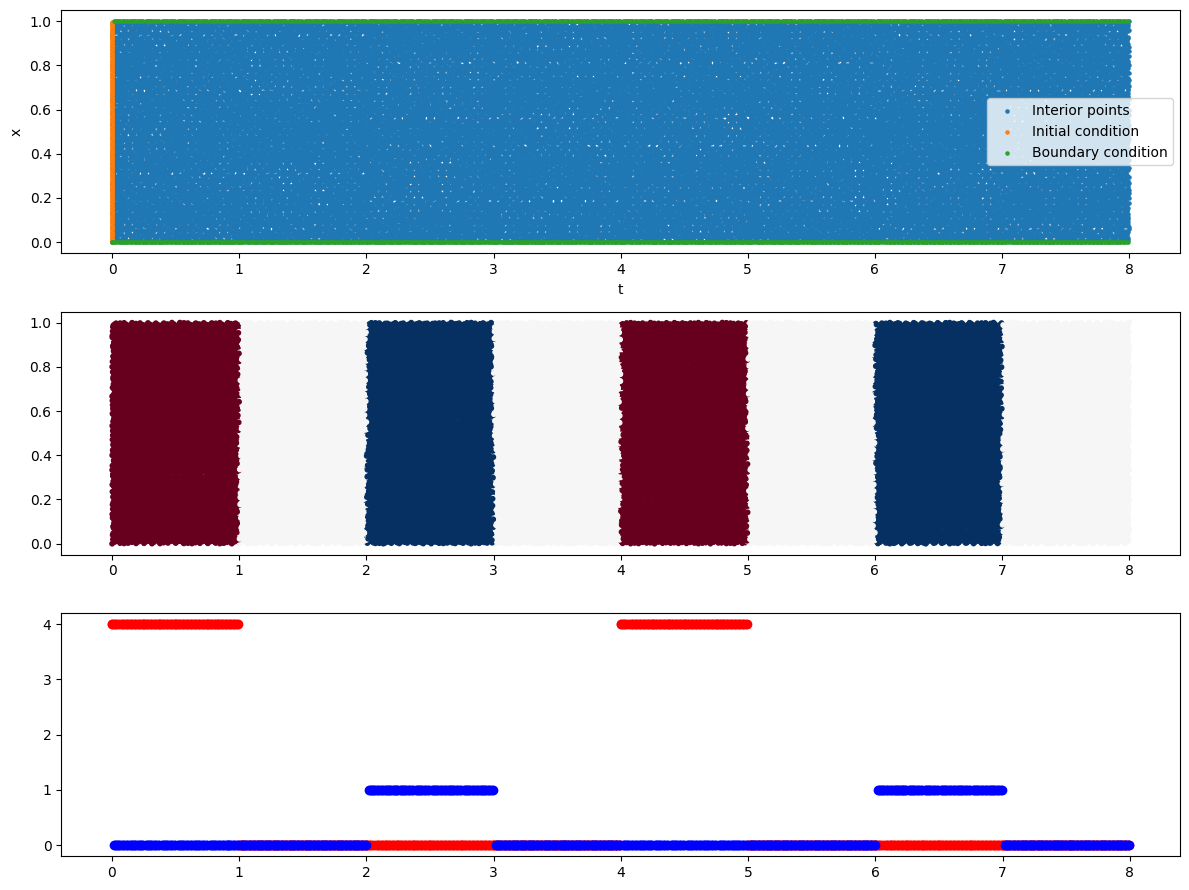

In [13]:
class FiniteBasisPINN(torch.nn.Module):

    def __init__(self, partition_ranges):
        super().__init__()
        self.n_doms = len(partition_ranges)
        self.dom_nets = torch.nn.ModuleList([pinn_core.uniform_MLP(in_dim=2, out_dim=1,
                                                             neurons=16, n_hidden_layers=3) for _ in range(self.n_doms)])
        for dom_net in self.dom_nets:
            dom_net.apply(pinn_core.linear_init_xavier)
        self.dom_nets.to(device)
        self.dom_jacs = [torch.tensor([1./(dom_range[1] - dom_range[0]), 1.]).to(device) for dom_range in partition_ranges]
        self.dom_init = [torch.tensor([dom_range[0], 0.]).to(device) for dom_range in partition_ranges]
        self.dom_cent = [(dom_range[0] + dom_range[1])/2 for dom_range in partition_ranges]

    def forward(self, x):
        y = [torch.exp(-((x[:, 0] - self.dom_cent[i_dom])*self.dom_jacs[i_dom][0])**6/2).unsqueeze(1)* \
             self.dom_nets[i_dom]((x - self.dom_init[i_dom])*self.dom_jacs[i_dom])
            for i_dom in range(self.n_doms)]
        return sum(y)


torch.manual_seed(42)
fbnn_f = FiniteBasisPINN([[-1., -0.5], [-0.5, 0.], [0., 0.5], [0.5, 1.0]])
fbnn_s = FiniteBasisPINN([[-1., -0.5], [-0.5, 0.], [0., 0.5], [0.5, 1.0]])

trange = [0., 8.]
xrange = [0., 1.]

pinn_2phase = PiNN_2Phase_Fluid(fbnn_f, fbnn_s,
                    train_input[train_input[:, 0] < trange[-1], :], train_output[train_input[:, 0] < trange[-1]],
                    loss_weights=[[1.,], [1., 1.], 1.],
                    domain=torch.tensor([trange, xrange]).to(device),
                    n_int=40000,
                    n_bound=[200, 800],
                    idx_bound=[(0,), (0, 1)],
                    bc_weight=[10., 1e-4],
                    device=device
                )

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))

ax = axes[0]
ax.scatter(pinn_2phase.data_interior[:, 0].detach().cpu().numpy(),
           pinn_2phase.data_interior[:, 1].detach().cpu().numpy(),
           s=5, label="Interior points")
ax.scatter(pinn_2phase.data_boundary[0][0][:, 0].detach().cpu().numpy(),
           pinn_2phase.data_boundary[0][0][:, 1].detach().cpu().numpy(),
           s=5, label="Initial condition")
ax.scatter(np.r_[pinn_2phase.data_boundary[1][0][:, 0].detach().cpu().numpy(),
                 pinn_2phase.data_boundary[1][1][:, 0].detach().cpu().numpy()],
           np.r_[pinn_2phase.data_boundary[1][0][:, 1].detach().cpu().numpy(),
                 pinn_2phase.data_boundary[1][1][:, 1].detach().cpu().numpy()],
            s=5, label="Boundary condition")
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.legend()

ax = axes[1]
im = ax.scatter(pinn_2phase.data_interior[:, 0].detach().cpu().numpy(),
                pinn_2phase.data_interior[:, 1].detach().cpu().numpy(),
                s=10, c=pinn_2phase.get_background_flow(pinn_2phase.data_interior[:, 0]).detach().cpu(), cmap="RdBu_r")
# plt.colorbar(im, ax=ax)

ax = axes[2]
ax.scatter(pinn_2phase.data_boundary[1][0][:, 0].detach().cpu(),
           pinn_2phase.bound_f[1][0].detach().cpu(), color='r', label="Upper boundary")
ax.scatter(pinn_2phase.data_boundary[1][1][:, 0].detach().cpu(),
           pinn_2phase.bound_f[1][1].detach().cpu(), color='b', label="Lower boundary")

plt.tight_layout()
plt.show()

### Training

In [ ]:
n_epochs_pre = 1000
verbose_epochs_pre = 100
n_epochs = 15
verbose_epochs = 1

# optimizer_pre = torch.optim.Adam(list(nn_phase_f.parameters()) + list(nn_phase_s.parameters()),
#                                  lr=3e-3, weight_decay=1.e-5)
# # scheduler_pre = torch.optim.lr_scheduler.StepLR(optimizer_pre, 500, gamma=0.5)
# optimizer = torch.optim.LBFGS(list(nn_phase_f.parameters()) + list(nn_phase_s.parameters()),
#                 lr=0.7, max_iter=1000, max_eval=1500,
#                 history_size=150, line_search_fn="strong_wolfe",
#                 tolerance_change=1.*np.finfo(float).eps)

optimizer_pre = torch.optim.Adam(list(fbnn_f.parameters()) + list(fbnn_s.parameters()),
                                 lr=3e-3, weight_decay=1.e-5)
optimizer = torch.optim.LBFGS(list(fbnn_f.parameters()) + list(fbnn_s.parameters()),
                lr=0.7, max_iter=1000, max_eval=1500,
                history_size=150, line_search_fn="strong_wolfe",
                tolerance_change=1.*np.finfo(float).eps)

hist_loss = list()
hist_Tf_misfit = list()
hist_Tf_pde = list()
hist_Tf_init = list()
hist_Tf_left = list()
hist_Tf_right = list()

def closure():
    optimizer.zero_grad()
    loss, loss_Tf_train, loss_Tf_pde, loss_Tf_bound = pinn_2phase.compute_loss()
    loss.backward()
    hist_loss.append(loss.detach().cpu().item())
    hist_Tf_misfit.append(loss_Tf_train.detach().cpu().item())
    hist_Tf_pde.append(loss_Tf_pde.detach().cpu().item())
    hist_Tf_init.append(loss_Tf_bound[0][0].detach().cpu().item())
    hist_Tf_left.append(loss_Tf_bound[1][0].detach().cpu().item())
    hist_Tf_right.append(loss_Tf_bound[1][1].detach().cpu().item())
    return loss

print("Gradient-based pre-training...")

epoch_split = [0]
for epoch in range(n_epochs_pre):
    optimizer_pre.step(closure=closure)
    # scheduler_pre.step()
    if (epoch + 1) % verbose_epochs_pre == 0:
        print("--------------- Epoch {:d} ---------------".format(epoch + 1))
        print("Average training loss = {:f}".format(np.array(hist_loss[epoch_split[-1]:]).mean()))
        epoch_split.append(len(hist_loss))

print("L-BFGS training...")

for epoch in range(n_epochs):

    optimizer.step(closure=closure)

    if (epoch + 1) % verbose_epochs == 0:
        print("--------------- Epoch {:d} ---------------".format(epoch + 1))
        print("Average training loss = {:f}".format(np.array(hist_loss[epoch_split[-1]:]).mean()))
        epoch_split.append(len(hist_loss))


Gradient-based pre-training...
--------------- Epoch 100 ---------------
Average training loss = 0.941383
--------------- Epoch 200 ---------------
Average training loss = 0.042205
--------------- Epoch 300 ---------------
Average training loss = -0.102575
--------------- Epoch 400 ---------------
Average training loss = -0.175756
--------------- Epoch 500 ---------------
Average training loss = -0.239663
--------------- Epoch 600 ---------------
Average training loss = 0.028789
--------------- Epoch 700 ---------------
Average training loss = 0.256274
--------------- Epoch 800 ---------------
Average training loss = 0.086391
--------------- Epoch 900 ---------------
Average training loss = -0.218667
--------------- Epoch 1000 ---------------
Average training loss = -0.399536
L-BFGS training...
--------------- Epoch 1 ---------------
Average training loss = -0.712502
--------------- Epoch 2 ---------------
Average training loss = -1.034286
--------------- Epoch 3 ---------------
Averag

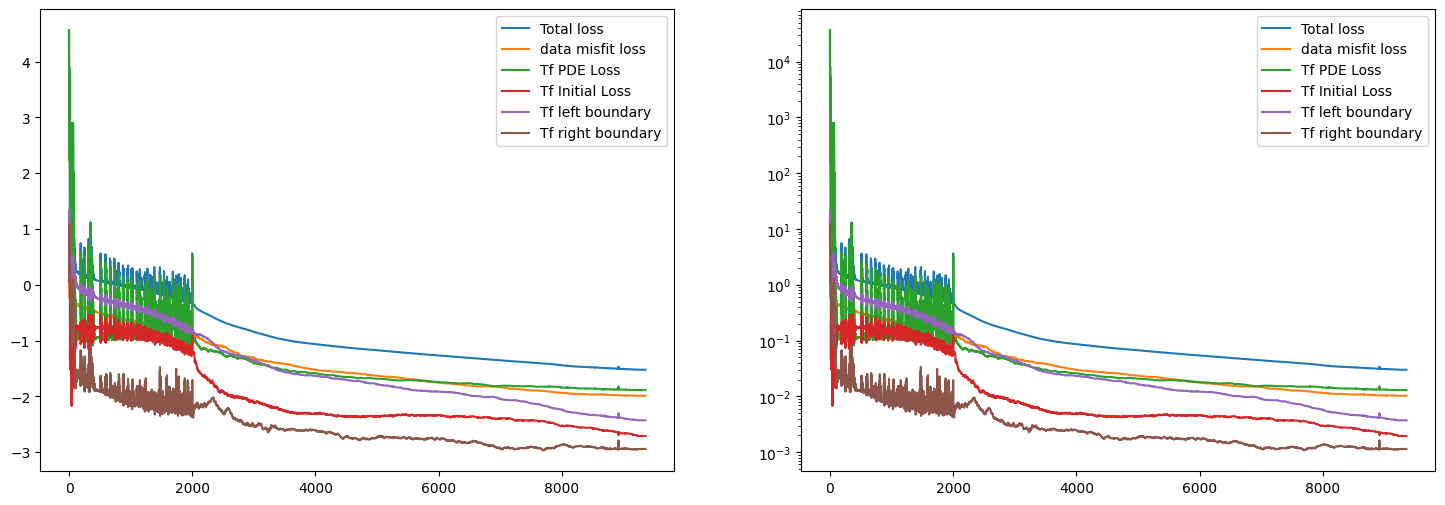

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

ax = axes[0]
ax.plot(hist_loss, label="Total loss")
ax.plot(np.log10(np.asarray(hist_Tf_misfit)), label="data misfit loss")
ax.plot(np.log10(np.asarray(hist_Tf_pde)), label="Tf PDE Loss")
ax.plot(np.log10(np.asarray(hist_Tf_init)), label="Tf Initial Loss")
ax.plot(np.log10(np.asarray(hist_Tf_left)), label="Tf left boundary")
ax.plot(np.log10(np.asarray(hist_Tf_right)), label="Tf right boundary")
# ax.set_xlim([3500, 3750])
ax.legend()

ax = axes[1]
ax.semilogy(np.power(10, np.asarray(hist_loss)), label="Total loss")
ax.plot(np.asarray(hist_Tf_misfit), label="data misfit loss")
ax.semilogy(pinn_2phase.wt[-1]*np.asarray(hist_Tf_pde), label="Tf PDE Loss")
ax.semilogy(pinn_2phase.wt[0][0]*np.asarray(hist_Tf_init), label="Tf Initial Loss")
ax.semilogy(pinn_2phase.wt[1][0]*np.asarray(hist_Tf_left), label="Tf left boundary")
ax.semilogy(pinn_2phase.wt[1][1]*np.asarray(hist_Tf_right), label="Tf right boundary")
# ax.set_xlim([3500, 3750])
ax.legend()

plt.show()

### Validation

<ipython-input-12-d887dfb89936>:46: RuntimeWarning: divide by zero encountered in log10
  s=10, c=np.log10(np.abs(Tf_res.detach().cpu().numpy())))


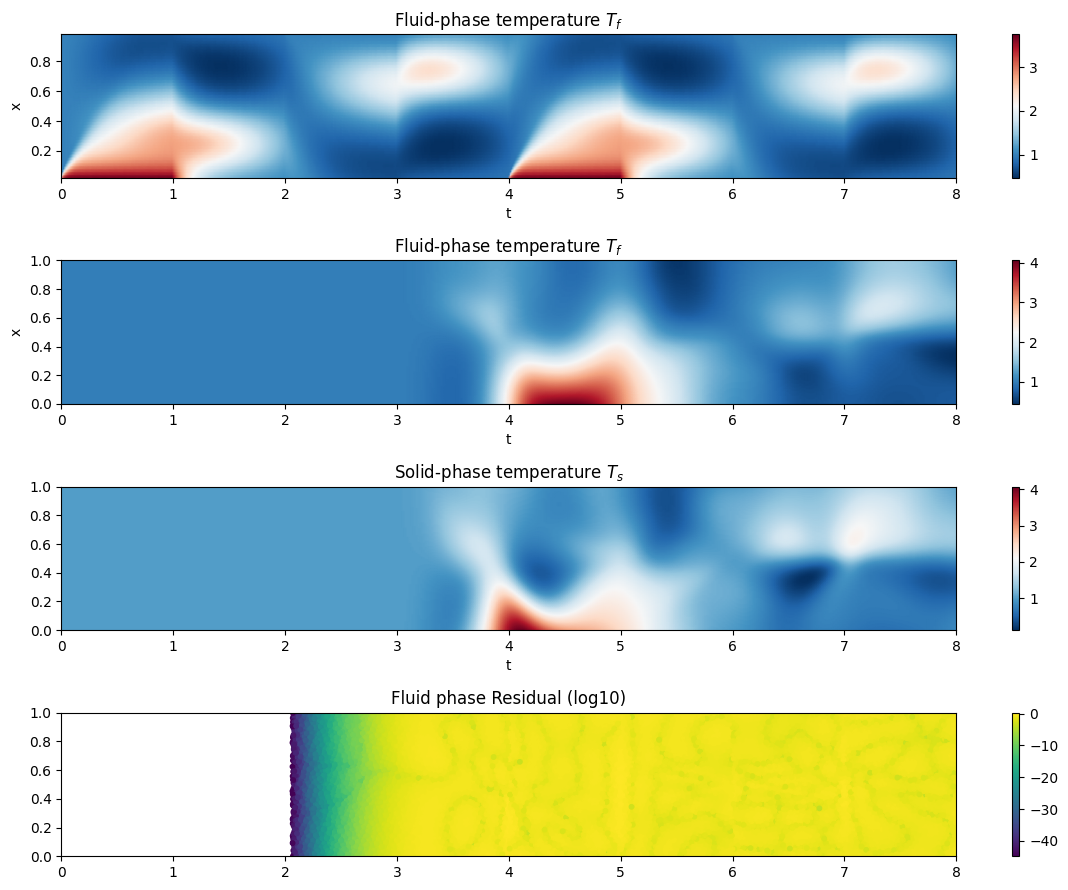

In [12]:
nx_plot, nt_plot = 200, 400
x_mesh, t_mesh = torch.meshgrid(torch.linspace(*xrange, nx_plot), torch.linspace(*trange, nt_plot), indexing='ij')
x_mesh = x_mesh.reshape(-1, )
t_mesh = t_mesh.reshape(-1, )
pt_eval = torch.stack((t_mesh, x_mesh), dim=1).to(device)
Tf_pred, Ts_pred = pinn_2phase.forward(pt_eval)
x_mesh = x_mesh.detach().reshape(nx_plot, nt_plot)
t_mesh = t_mesh.detach().reshape(nx_plot, nt_plot)
Tf_pred = Tf_pred.detach().cpu().reshape(nx_plot, nt_plot)
Ts_pred = Ts_pred.detach().cpu().reshape(nx_plot, nt_plot)

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 9))

ax = axes[0]
im = ax.pcolormesh(train_input[:, 0].detach().cpu().reshape(49, 800),
                   train_input[:, 1].detach().cpu().reshape(49, 800),
                   train_output.detach().cpu().reshape(49, 800), cmap="RdBu_r", shading="gouraud")
plt.colorbar(im, ax=ax)
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_title("Fluid-phase temperature $T_f$")

clip_limits = None
time_limits = [0., 8.]

ax = axes[1]
im = ax.pcolormesh(t_mesh, x_mesh, Tf_pred, cmap="RdBu_r", shading="gouraud", clim=clip_limits)
plt.colorbar(im, ax=ax)
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_xlim(time_limits)
ax.set_title("Fluid-phase temperature $T_f$")

ax = axes[2]
im = ax.pcolormesh(t_mesh, x_mesh, Ts_pred, cmap="RdBu_r", shading="gouraud", clim=clip_limits)
plt.colorbar(im, ax=ax)
ax.set_xlabel("t")
ax.set_xlim(time_limits)
ax.set_title("Solid-phase temperature $T_s$")


Tf_res = pinn_2phase.residual(pinn_2phase.data_interior)
ax = axes[3]
im = ax.scatter(pinn_2phase.data_interior[:, 0].detach().cpu().numpy(),
                pinn_2phase.data_interior[:, 1].detach().cpu().numpy(),
                s=10, c=np.log10(np.abs(Tf_res.detach().cpu().numpy())))
plt.colorbar(im, ax=ax)
ax.set_title("Fluid phase Residual (log10)")
ax.set_xlim(time_limits)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

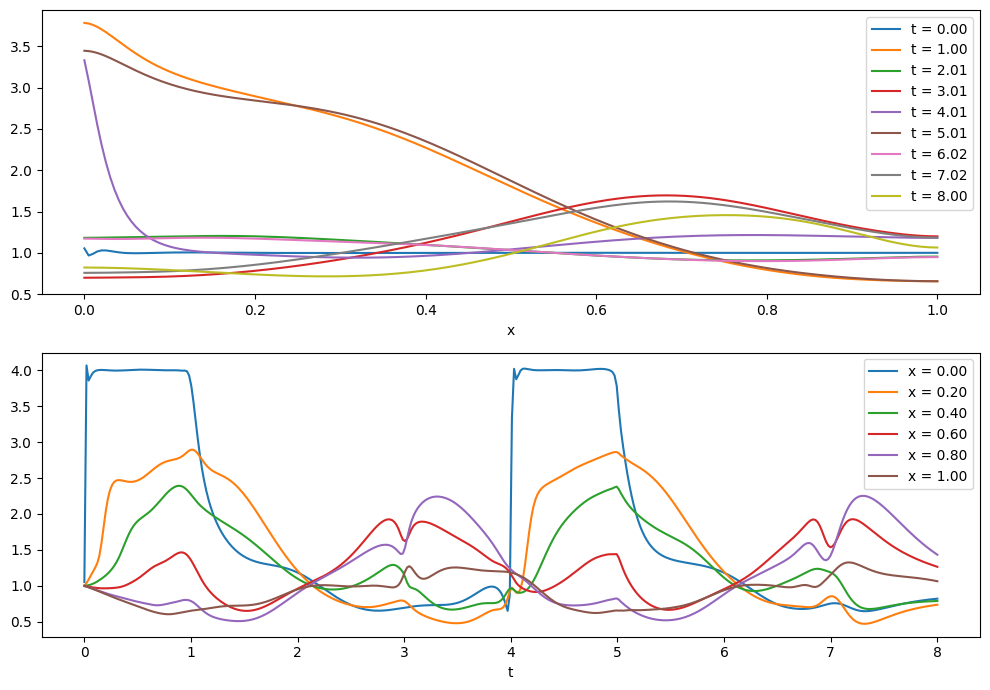

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))

ax = axes[0]
for i_t in range(0, nt_plot, nt_plot // 8):
    ax.plot(x_mesh[:, i_t], Tf_pred[:, i_t], label="t = {:.2f}".format(t_mesh[0, i_t]))
ax.plot(x_mesh[:, -1], Tf_pred[:, -1], label="t = {:.2f}".format(t_mesh[0, -1]))
ax.set_xlabel("x")
ax.legend()

ax = axes[1]
for i_x in range(0, nx_plot, nx_plot // 5):
    ax.plot(t_mesh[i_x, :], Tf_pred[i_x, :], label="x = {:.2f}".format(x_mesh[i_x, 0]))
ax.plot(t_mesh[-1, :], Tf_pred[-1, :], label="x = {:.2f}".format(x_mesh[-1, 0]))
ax.set_xlabel("t")
ax.legend()
# ax.set_xlim([0, 0.05])

plt.tight_layout()
plt.show()

In [ ]:
torch.save(nn_phase_f.state_dict(), "./drive/MyDrive/Colab Notebooks/two-phase_thermal/inverted_Tf_single-3x32.pth")
torch.save(nn_phase_s.state_dict(), "./drive/MyDrive/Colab Notebooks/two-phase_thermal/inverted_Ts_single-3x32.pth")

### Prediction

In [ ]:
nn_phase_f.load_state_dict(torch.load("./drive/MyDrive/Colab Notebooks/two-phase_thermal/inverted_Tf_single-3x32.pth"))
nn_phase_s.load_state_dict(torch.load("./drive/MyDrive/Colab Notebooks/two-phase_thermal/inverted_Ts_single-3x32.pth"))
nn_phase_f.to(device)
nn_phase_s.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): Tanh()
  (8): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
import pandas as pd

test_ds = pd.read_csv("./drive/MyDrive/Colab Notebooks/two-phase_thermal/Task2/SubExample.txt", header=0)
test_ds

t     x   ts
0      0.000000  0.02  0.0
1      0.010013  0.02  0.0
2      0.020025  0.02  0.0
3      0.030038  0.02  0.0
4      0.040050  0.02  0.0
...         ...   ...  ...
39195  7.959950  0.98  0.0
39196  7.969963  0.98  0.0
39197  7.979975  0.98  0.0
39198  7.989988  0.98  0.0
39199  8.000000  0.98  0.0

[39200 rows x 3 columns]

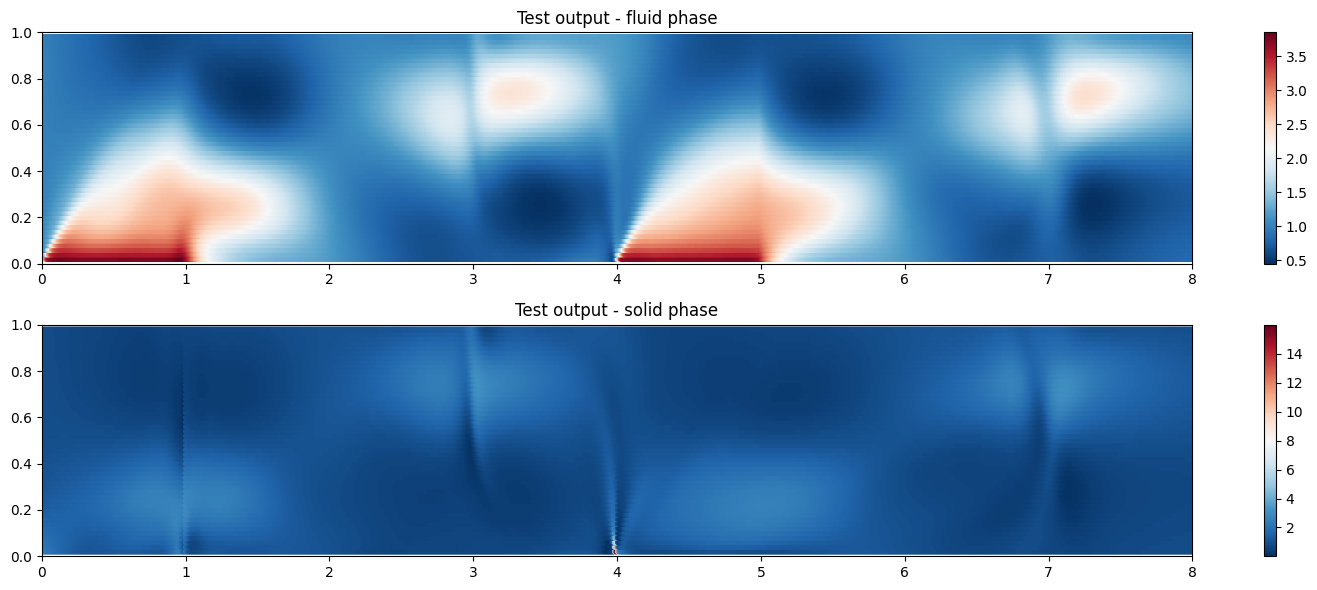

t     x        ts
0      0.000000  0.02  2.468469
1      0.010013  0.02  2.412984
2      0.020025  0.02  2.356972
3      0.030038  0.02  2.300562
4      0.040050  0.02  2.243895
...         ...   ...       ...
39195  7.959950  0.98  0.984289
39196  7.969963  0.98  0.982548
39197  7.979975  0.98  0.980812
39198  7.989988  0.98  0.979085
39199  8.000000  0.98  0.977368

[39200 rows x 3 columns]

In [ ]:
test_tensor = torch.from_numpy(test_ds.iloc[:, :2].to_numpy()).to(torch.float32).to(device)
test_output_f, test_output_s = pinn_2phase.forward(test_tensor)

time_limits = [0., 8.]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
ax = axes[0]
im = ax.scatter(test_tensor[:, 0].detach().cpu().numpy(),
                test_tensor[:, 1].detach().cpu().numpy(),
                s=10, c=np.abs(test_output_f.detach().cpu().numpy()), cmap="RdBu_r")
plt.colorbar(im, ax=ax)
ax.set_title("Test output - fluid phase")
ax.set_xlim(time_limits)
ax.set_ylim([0., 1.])

ax = axes[1]
im = ax.scatter(test_tensor[:, 0].detach().cpu().numpy(),
                test_tensor[:, 1].detach().cpu().numpy(),
                s=10, c=np.abs(test_output_s.detach().cpu().numpy()), cmap="RdBu_r")
plt.colorbar(im, ax=ax)
ax.set_title("Test output - solid phase")
ax.set_xlim(time_limits)
ax.set_ylim([0., 1.])

plt.tight_layout()
plt.show()

# test_ds["tf"] = test_output_f.detach().cpu().numpy()
test_ds["ts"] = test_output_s.detach().cpu().numpy()
test_ds

In [ ]:
test_ds.to_csv("./drive/MyDrive/Colab Notebooks/two-phase_thermal/Task2/Task2_single-3x32.txt", index=False)

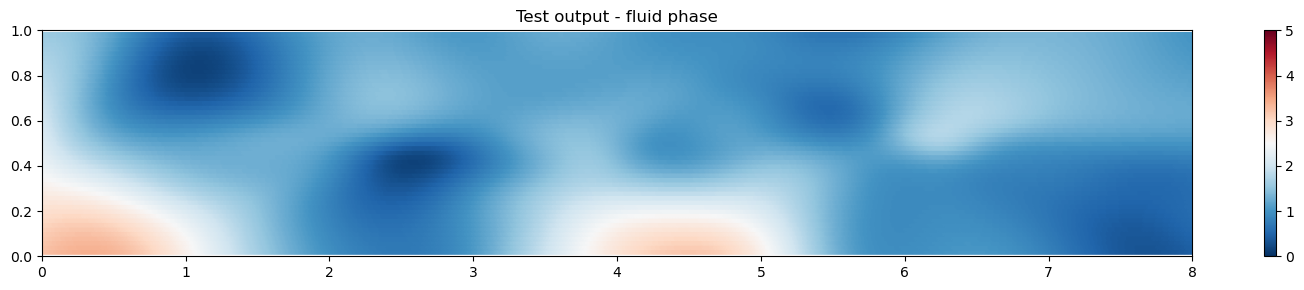

In [18]:
import os
base_url = "C:/Users/gentle/Documents/Curricula/Machine_Learning/SciDL/PA_Y23/Task2/"
# test_ds = pd.read_csv(os.path.join(base_url, "Task2_single-3x32.txt"), header=0)
# test_ds = pd.read_csv(os.path.join(base_url, "Task2_fb-3x16.txt"), header=0)
test_ds = pd.read_csv(os.path.join(base_url, "Task2_temp.txt"), header=0)

time_limits = [0., 8.]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
ax = axes
im = ax.scatter(test_ds['t'], test_ds['x'],
                s=10, c=test_ds["ts"], cmap="RdBu_r", clim=[0., 5.])
plt.colorbar(im, ax=ax)
ax.set_title("Test output - fluid phase")
ax.set_xlim(time_limits)
ax.set_ylim([0., 1.])

plt.tight_layout()
plt.show()

## Heat equation, not coupled

The same system, but not coupled, only one phase.
Just to test whether the boundary condition can be easily observed.

In [ ]:
class PiNN_ThermalNet(pinn_core.PiNN_Cartesian):

    def __init__(self, forward_approx_f, *args,
                 diffuse_f=0.05, background_flow=1., T0=1., Th=4.,
                 **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.approximator_f = forward_approx_f
        self.diffuse_f = diffuse_f
        self.U0 = background_flow
        self.bound = self.boundary_condition(T0, Th)

    def boundary_condition(self, T0, Th):
        bound = list()
        bound.append([T0*torch.ones(self.data_boundary[0][0].shape[0]).to(device),])
        bound.append([T0 + (Th - T0)/(1. + torch.exp(-200.*(self.data_boundary[1][0][:, 0] - 0.25))),
                      torch.zeros(self.data_boundary[1][1].shape[0]).to(device),])
        return bound

    def forward(self, x_input):
        return 3*self.approximator_f(self.normalize(x_input)) + 1.

    def residual(self, x_int):
        x_int.requires_grad = True
        Tf = self.forward(x_input=x_int)

        grad_Tf = torch.autograd.grad(Tf.sum(), x_int, create_graph=True)[0]
        dTf_dt = grad_Tf[:, 0]
        dTf_dx = grad_Tf[:, 1]
        d2Tf_dx2 = torch.autograd.grad(dTf_dx.sum(), x_int, create_graph=True)[0][:, 1]

        res_Tf = dTf_dt + self.U0*dTf_dx - self.diffuse_f*d2Tf_dx2
        return res_Tf

    def boundary_loss(self):

        Tf_init = self.forward(self.data_boundary[0][0])
        loss_init = torch.mean((Tf_init.reshape(-1, ) - self.bound[0][0])**2)

        Tf_lbound = self.forward(self.data_boundary[1][0])
        loss_lbound = torch.mean((Tf_lbound.reshape(-1, ) - self.bound[1][0])**2)

        self.data_boundary[1][1].requires_grad = True
        Tf_rbound = self.forward(self.data_boundary[1][1])
        dTf_dx_r = torch.autograd.grad(Tf_rbound.sum(), self.data_boundary[1][1], create_graph=True)[0][:, 1]
        loss_rbound = torch.mean((dTf_dx_r - self.bound[1][1])**2)

        return [[loss_init, ], [loss_lbound, loss_rbound]]

    def compute_loss(self):
        res_pde = self.residual(self.data_interior)
        loss_pde = torch.mean(res_pde**2)
        loss_boundary = self.boundary_loss()
        loss = torch.log10(1*loss_pde
                           + self.bc_weight[0][0]*loss_boundary[0][0]
                           + self.bc_weight[1][0]*loss_boundary[1][0]
                           + self.bc_weight[1][1]*loss_boundary[1][1])
        return loss, loss_pde, loss_boundary

### The neural network

- Multilayer perceptron (fully-connected network)
- 32 neurons, 2 hidden layers
- 1024 interior sampling points, 128 sampling points for all boundaries
- Double-sided spacial boundary condition
- Single-sided temporal boundary condition (initial condition)

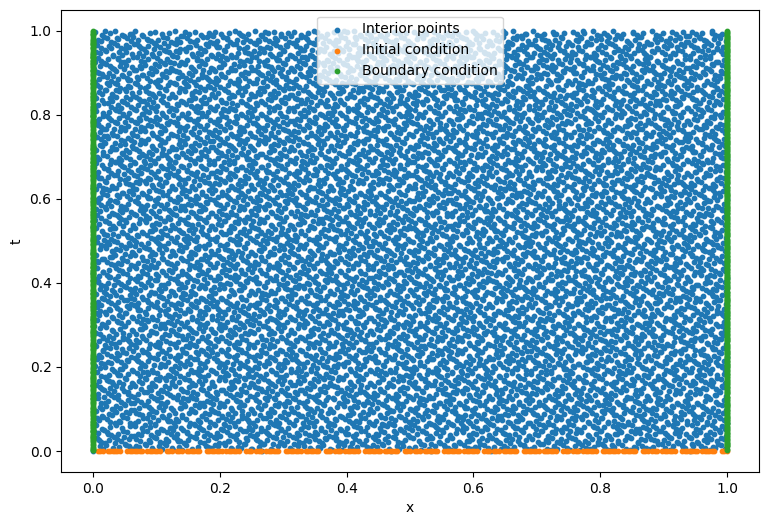

In [ ]:
torch.manual_seed(42)
# Fluid phase network
nn_phase_f = pinn_core.uniform_MLP(in_dim=2, out_dim=1,
                                   neurons=32, n_hidden_layers=3)
nn_phase_f.apply(pinn_core.linear_init_xavier)
nn_phase_f.to(device)

pinn_2phase = PiNN_ThermalNet(nn_phase_f,
                    domain=torch.tensor([[0., 1.], [0., 1.]]).to(device),
                    n_int=10000,
                    n_bound=[200, 400],
                    idx_bound=[(0,), (0, 1)],
                    bc_weight=[(1.,), (1., 1.)],
                    device=device
                )

plt.figure(figsize=(9, 6))
plt.scatter(pinn_2phase.data_interior[:, 1].detach().cpu().numpy(),
            pinn_2phase.data_interior[:, 0].detach().cpu().numpy(),
            s=10, label="Interior points")
plt.scatter(pinn_2phase.data_boundary[0][0][:, 1].detach().cpu().numpy(),
            pinn_2phase.data_boundary[0][0][:, 0].detach().cpu().numpy(),
            s=10, label="Initial condition")
plt.scatter(np.r_[pinn_2phase.data_boundary[1][0][:, 1].detach().cpu().numpy(),
                  pinn_2phase.data_boundary[1][1][:, 1].detach().cpu().numpy()],
            np.r_[pinn_2phase.data_boundary[1][0][:, 0].detach().cpu().numpy(),
                  pinn_2phase.data_boundary[1][1][:, 0].detach().cpu().numpy()],
            s=10, label="Boundary condition")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

### Training

Gradient-based training...
--------------- Epoch 100 ---------------
Average training loss = 0.162620
--------------- Epoch 200 ---------------
Average training loss = -0.511225
--------------- Epoch 300 ---------------
Average training loss = -0.649154
--------------- Epoch 400 ---------------
Average training loss = -0.735183
--------------- Epoch 500 ---------------
Average training loss = -0.789374
--------------- Epoch 600 ---------------
Average training loss = -0.829770
--------------- Epoch 700 ---------------
Average training loss = -0.866204
--------------- Epoch 800 ---------------
Average training loss = -0.900359
--------------- Epoch 900 ---------------
Average training loss = -0.932622
--------------- Epoch 1000 ---------------
Average training loss = -0.962709
--------------- Epoch 1100 ---------------
Average training loss = -0.991055
--------------- Epoch 1200 ---------------
Average training loss = -1.017001
--------------- Epoch 1300 ---------------
Average training

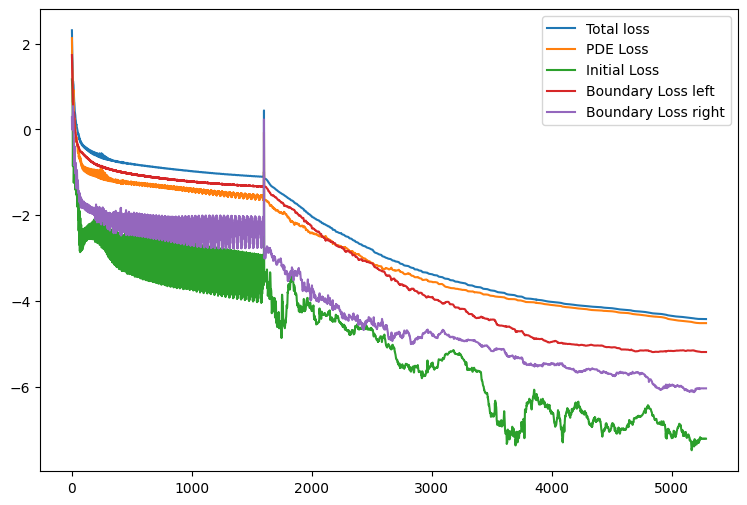

In [ ]:
n_epochs_pre = 1600
verbose_epochs_pre = 100
n_epochs = 10
verbose_epochs = 1

optimizer_pre = torch.optim.Adam(nn_phase_f.parameters(),
                                 lr=1e-3, weight_decay=1.e-5)
optimizer = torch.optim.LBFGS(nn_phase_f.parameters(),
                lr=1.0, max_iter=1000, max_eval=1500,
                history_size=150, line_search_fn="strong_wolfe",
                tolerance_change=1.*np.finfo(float).eps)

hist_loss = list()
hist_Tf_pde = list()
hist_Tf_init = list()
hist_Tf_left = list()
hist_Tf_right = list()

def closure():
    optimizer.zero_grad()
    loss, loss_Tf_pde, loss_Tf_bound, = pinn_2phase.compute_loss()
    loss.backward()

    hist_loss.append(loss.detach().cpu().item())
    hist_Tf_pde.append(loss_Tf_pde.detach().cpu().item())
    hist_Tf_init.append(loss_Tf_bound[0][0].detach().cpu().item())
    hist_Tf_left.append(loss_Tf_bound[1][0].detach().cpu().item())
    hist_Tf_right.append(loss_Tf_bound[1][1].detach().cpu().item())
    return loss

print("Gradient-based training...")

epoch_split = [0]
for epoch in range(n_epochs_pre):
    optimizer_pre.step(closure=closure)
    if (epoch + 1) % verbose_epochs_pre == 0:
        print("--------------- Epoch {:d} ---------------".format(epoch + 1))
        print("Average training loss = {:f}".format(np.array(hist_loss[epoch_split[-1]:]).mean()))
        epoch_split.append(len(hist_loss))

print("L-BFGS training...")

for epoch in range(n_epochs):

    optimizer.step(closure=closure)

    if (epoch + 1) % verbose_epochs == 0:
        print("--------------- Epoch {:d} ---------------".format(epoch + 1))
        print("Average training loss = {:f}".format(np.array(hist_loss[epoch_split[-1]:]).mean()))
        epoch_split.append(len(hist_loss))


plt.figure(figsize=(9, 6))
plt.plot(hist_loss, label="Total loss")
plt.plot(np.log10(np.asarray(hist_Tf_pde)), label="PDE Loss")
plt.plot(np.log10(np.asarray(hist_Tf_init)), label="Initial Loss")
plt.plot(np.log10(np.asarray(hist_Tf_left)), label="Boundary Loss left")
plt.plot(np.log10(np.asarray(hist_Tf_right)), label="Boundary Loss right")
plt.legend()
plt.show()

### Validation

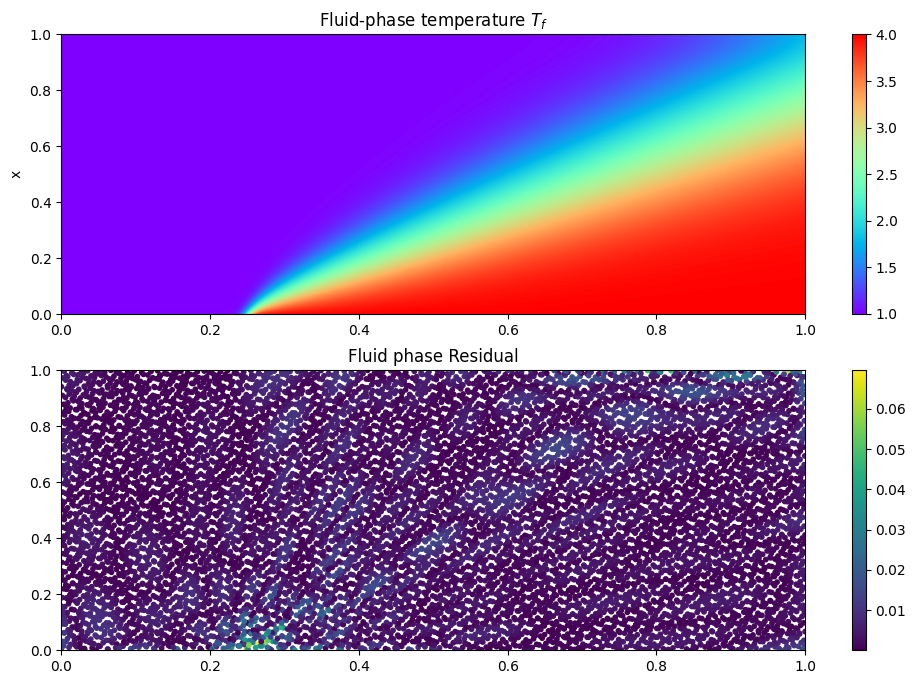

In [ ]:
nx_plot, nt_plot = 500, 500
x_eval, t_eval = torch.meshgrid(torch.linspace(0., 1, nx_plot), torch.linspace(0, 1., nt_plot), indexing='ij')
x_eval = x_eval.reshape(-1, )
t_eval = t_eval.reshape(-1, )
pt_eval = torch.stack((t_eval, x_eval), dim=1).to(device)
pt_eval.requires_grad = True
x_mesh = x_eval.detach().reshape(nx_plot, nt_plot)
t_mesh = t_eval.detach().reshape(nx_plot, nt_plot)

Tf_pred = pinn_2phase.forward(pt_eval)
dTf_dx_pred = torch.autograd.grad(Tf_pred.sum(), pt_eval)[0][:, 1]
dTf_dx_pred = dTf_dx_pred.detach().cpu().reshape(nx_plot, nt_plot)
Tf_pred = Tf_pred.detach().cpu().reshape(nx_plot, nt_plot)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
ax = axes[0]
im = ax.pcolormesh(t_mesh, x_mesh, Tf_pred, cmap="rainbow", shading="gouraud")
plt.colorbar(im, ax=ax)
ax.set_ylabel("x")
ax.set_title("Fluid-phase temperature $T_f$")

test_res = pinn_2phase.residual(pinn_2phase.data_interior)
ax = axes[1]
im = ax.scatter(pinn_2phase.data_interior[:, 0].detach().cpu().numpy(),
                pinn_2phase.data_interior[:, 1].detach().cpu().numpy(),
                s=10, c=np.abs(test_res.detach().cpu().numpy()))
plt.colorbar(im, ax=ax)
ax.set_title("Fluid phase Residual")
ax.set_xlim([0., 1.])
ax.set_ylim([0., 1.])

plt.show()

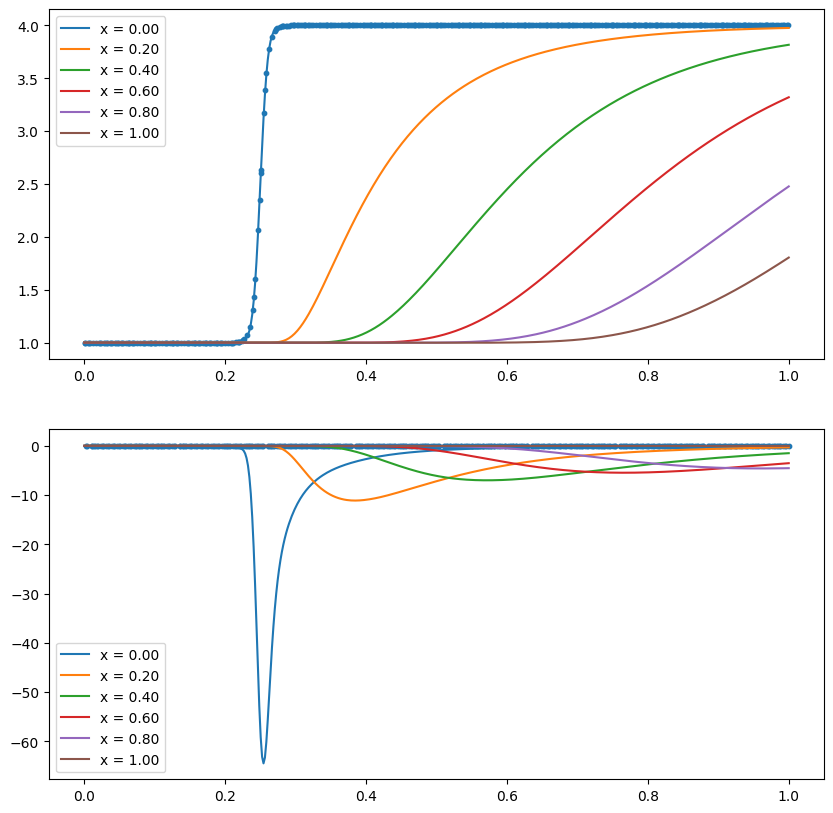

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax = axes[0]
ax.scatter(pinn_2phase.data_boundary[1][0][:, 0].detach().cpu(), pinn_2phase.bound[1][0].detach().cpu(), s=10)
for i in range(0, nx_plot, nx_plot // 5):
    ax.plot(t_mesh[i, :], Tf_pred[i, :], label="x = {:.2f}".format(x_mesh[i, 0]))
ax.plot(t_mesh[-1, :], Tf_pred[-1, :], label="x = {:.2f}".format(x_mesh[-1, 0]))
ax.legend()

ax = axes[1]
ax.scatter(pinn_2phase.data_boundary[1][1][:, 0].detach().cpu(), pinn_2phase.bound[1][1].detach().cpu(), s=10)
for i in range(0, nx_plot, nx_plot // 5):
    ax.plot(t_mesh[i, :], dTf_dx_pred[i, :], label="x = {:.2f}".format(x_mesh[i, 0]))
ax.plot(t_mesh[-1, :], dTf_dx_pred[-1, :], label="x = {:.2f}".format(x_mesh[-1, 0]))
ax.legend()

plt.show()

## Time series prediction using neural operator

### Preprocess time series to training datasets

In [3]:
import os
base_path = "C:/Users/gentle/Documents/Curricula/Machine_Learning/SciDL/PA_Y23/Task3/"

tseries = pd.read_csv(os.path.join(base_path, "TrainingData.txt"), header=0)

len_tseries = tseries.shape[0]
len_i = 34
io_stride = len_i
len_o = 34

np.random.seed(42)
n_samples = 150
idx_start_array = np.random.randint(0, len_tseries - len_i - len_o, size=n_samples)
ds_i = np.zeros((n_samples, len_i, 3))
ds_o = np.zeros((n_samples, len_o, 3))

for i_sample, i_start in enumerate(idx_start_array):
    ds_i[i_sample] = tseries.iloc[i_start:i_start+len_i, :].to_numpy()
    ds_o[i_sample] = tseries.iloc[i_start+io_stride:i_start+io_stride+len_o, :].to_numpy()

np.save(os.path.join(base_path, "tsamples_i.npy"), ds_i)
np.save(os.path.join(base_path, "tsamples_o.npy"), ds_o)

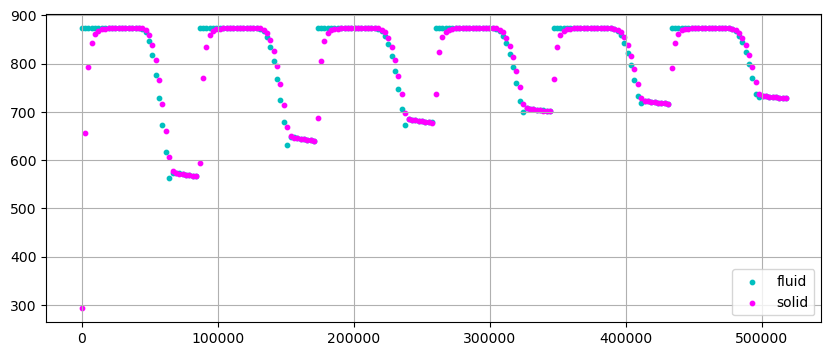

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

ax = axes
ax.scatter(tseries["t"], tseries["tf0"], s=10, color='c', label="fluid")
ax.scatter(tseries["t"], tseries["ts0"], s=10, color='magenta', label="solid")
ax.legend()
ax.grid()

plt.show()

### Read in the dataset

In [ ]:
tseries = pd.read_csv("./drive/MyDrive/Colab Notebooks/two-phase_thermal/Task3/TrainingData.txt", header=0)
ds_i = np.load("./drive/MyDrive/Colab Notebooks/two-phase_thermal/tsamples_i.npy")
ds_o = np.load("./drive/MyDrive/Colab Notebooks/two-phase_thermal/tsamples_o.npy")
tseries

t         tf0         ts0
0         0.00  873.000000  293.000000
1      2478.06  873.000000  655.920736
2      4956.12  873.000000  792.106226
3      7434.18  873.000000  842.176577
4      9912.24  873.000000  861.040655
..         ...         ...         ...
205  508002.30  730.794575  730.514961
206  510480.36  730.053663  729.797475
207  512958.42  729.371039  729.133162
208  515436.48  728.734400  728.511278
209  517914.54  728.135229  727.924326

[210 rows x 3 columns]

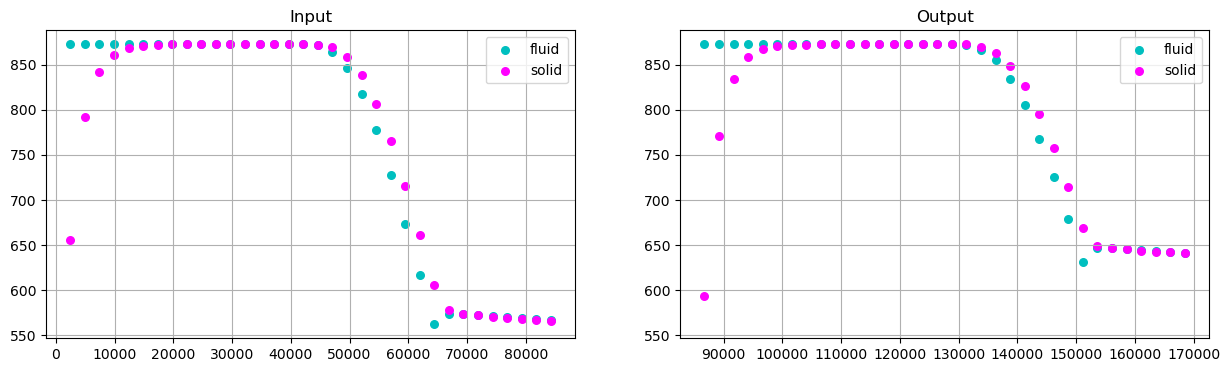

In [5]:
i_show = 15

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

min_val = min([ds_i[i_show, :, 1].min(), ds_i[i_show, :, 2].min(), ds_o[i_show, :, 1].min(), ds_o[i_show, :, 2].min()])
max_val = min([ds_i[i_show, :, 1].max(), ds_i[i_show, :, 2].max(), ds_o[i_show, :, 1].max(), ds_o[i_show, :, 2].max()])
range_pad = (max_val - min_val)*0.05

ax = axes[0]
ax.scatter(ds_i[i_show, :, 0], ds_i[i_show, :, 1], s=30, color='c', label="fluid")
ax.scatter(ds_i[i_show, :, 0], ds_i[i_show, :, 2], s=30, color='magenta', label="solid")
ax.legend()
ax.grid()
ax.set_ylim([min_val - range_pad, max_val + range_pad])
ax.set_title("Input")

ax = axes[1]
ax.scatter(ds_o[i_show, :, 0], ds_o[i_show, :, 1], s=30, color='c', label="fluid")
ax.scatter(ds_o[i_show, :, 0], ds_o[i_show, :, 2], s=30, color='magenta', label="solid")
ax.legend()
ax.grid()
ax.set_ylim([min_val - range_pad, max_val + range_pad])
ax.set_title("Output")

plt.show()

### Fourier Neural Operator

In [6]:
class SpectralConv1d(torch.nn.Module):

    def __init__(self, in_channels, out_channels, n_modes):
        super().__init__()
        self.n_chann_i = in_channels
        self.n_chann_o = out_channels
        self.n_modes = n_modes
        self.scale = 1/(self.n_chann_i*self.n_chann_o)
        self.weights = torch.nn.Parameter(self.scale*torch.rand(self.n_chann_i, self.n_chann_o, self.n_modes, dtype=torch.cfloat))

    def fd_mul(self, inputs, weights):
        return torch.einsum("bix,iox->box", inputs, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        nfft = x.shape[-1]
        x_fd = torch.fft.rfft(x, dim=-1)
        out_fd = torch.zeros(batchsize, self.n_chann_o, nfft // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_fd[:, :, :self.n_modes] = self.fd_mul(x_fd[:, :, :self.n_modes], self.weights)
        out = torch.fft.irfft(out_fd, n=nfft, dim=-1)
        return out


class FourierNeuralOp1d(torch.nn.Module):

    def __init__(self, in_channels, out_channels, n_modes, width):

        super().__init__()
        self.n_chann_i = in_channels
        self.n_chann_o = out_channels
        self.n_modes = n_modes
        self.width = width

        self.linear_in = torch.nn.Linear(self.n_chann_i, self.width)
        self.fdconv_1 = SpectralConv1d(self.width, self.width, self.n_modes)
        self.lin_1 = torch.nn.Conv1d(self.width, self.width, 1)
        self.fdconv_2 = SpectralConv1d(self.width, self.width, self.n_modes)
        self.lin_2 = torch.nn.Conv1d(self.width, self.width, 1)
        self.fdconv_3 = SpectralConv1d(self.width, self.width, self.n_modes)
        self.lin_3 = torch.nn.Conv1d(self.width, self.width, 1)
        self.linear_merge = torch.nn.Linear(self.width, 32)
        self.linear_out = torch.nn.Linear(32, self.n_chann_o)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def dense_layer(self, x, linear_layer):
        return self.activation(linear_layer(x))

    def forward(self, x):
        x = self.linear_in(x)
        x = x.permute(0, 2, 1)
        x = self.fourier_layer(x, self.fdconv_1, self.lin_1)
        x = self.fourier_layer(x, self.fdconv_2, self.lin_2)
        x = self.fourier_layer(x, self.fdconv_3, self.lin_3)
        x = x.permute(0, 2, 1)
        x = self.dense_layer(x, self.linear_merge)
        x = self.linear_out(x)
        return x


### Input-output normalization

In [7]:
temp_min = tseries.iloc[:, 1:].min().min()
temp_max = tseries.iloc[:, 1:].max().max()
t_len = np.ceil(ds_i[0, -1, 0] - ds_i[0, 0, 0])

x_data = torch.from_numpy(ds_i).type(torch.float32).clone()
y_data = torch.from_numpy(ds_o[:, :, 1:]).type(torch.float32).clone()

def normalize_therm(inputs):
    # return (inputs - temp_min)/(temp_max - temp_min)
    return (temp_max - inputs)/(temp_max - temp_min)

def denormalize_therm(inputs):
    # return temp_min + inputs*(temp_max - temp_min)
    return temp_max - inputs*(temp_max - temp_min)

x_data[:, :, 0] = (x_data[:, :, 0].T - x_data[:, 0, 0]).T/t_len
x_data[:, :, 1:] = normalize_therm(x_data[:, :, 1:])
y_data = normalize_therm(y_data)

n_train = 100

input_function_train = x_data[:n_train, :]
output_function_train = y_data[:n_train, :]
input_function_test = x_data[n_train:, :]
output_function_test = y_data[n_train:, :]

batch_size = 10

training_set = DataLoader(TensorDataset(input_function_train, output_function_train), batch_size=batch_size, shuffle=True)
testing_set = DataLoader(TensorDataset(input_function_test, output_function_test), batch_size=batch_size, shuffle=False)

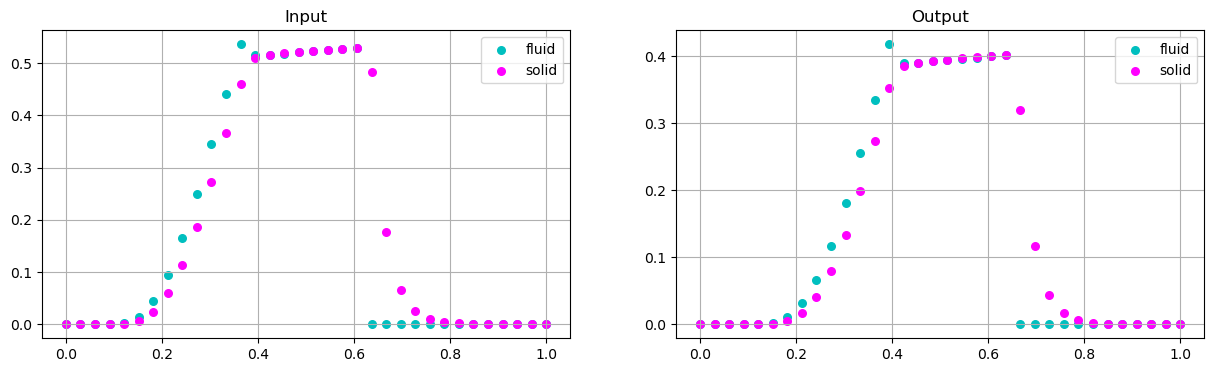

In [8]:
i_show = 25

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax = axes[0]
ax.scatter(x_data[i_show, :, 0], x_data[i_show, :, 1], s=30, color='c', label="fluid")
ax.scatter(x_data[i_show, :, 0], x_data[i_show, :, 2], s=30, color='magenta', label="solid")
ax.legend()
ax.grid()
ax.set_title("Input")

ax = axes[1]
ax.scatter(x_data[i_show, :, 0], y_data[i_show, :, 0], s=30, color='c', label="fluid")
ax.scatter(x_data[i_show, :, 0], y_data[i_show, :, 1], s=30, color='magenta', label="solid")
ax.legend()
ax.grid()
ax.set_title("Output")

plt.show()

### Training

In [26]:
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.5

modes = 16
width = 128

fno = FourierNeuralOp1d(3, 2, modes, width)

optimizer = torch.optim.Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

refine_epochs = 5
optimizer_refine = torch.optim.LBFGS(fno.parameters(),
                                     lr=0.5, max_iter=500, history_size=150,
                                     line_search_fn="strong_wolfe")

In [27]:
l_mse = torch.nn.MSELoss()

freq_print = 50
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = l_mse(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()

    with torch.no_grad():
        fno.eval()
        test_mse = 0.0
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = l_mse(output_pred_batch, output_batch)
            test_mse += loss_f.item()
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_mse /= len(testing_set)
        test_relative_l2 /= len(testing_set)

    if epoch % freq_print == 0:
        print("------------ Epoch: {:4d} ------ Train loss: {:.5f} ------ Test loss: {:.5f} ------ Relative L2 misfit: {:6.2f}".format(epoch+1, train_mse, test_mse, test_relative_l2))

# L-BFGS seems unable to work on complex layers, see
# https://stackoverflow.com/questions/74574823/can-pytorch-l-bfgs-be-used-to-optimize-a-complex-parameter
# One has to modify the dot product in pytorch source file `lbfgs.py` to allow for correctly handle
# intermediate complex derivatives, which cannot be done on CoLab anyway

# print("L-BFGS refinement...")

# def closure():
#     optimizer_refine.zero_grad()
#     output_pred = fno(input_function_train)
#     loss = l_mse(output_pred, output_function_train)
#     loss.backward()
#     return loss

# for refine_epoch in range(refine_epochs):
#     train_mse = optimizer_refine.step(closure=closure).item()

#     with torch.no_grad():
#         fno.eval()
#         output_pred = fno(input_function_test)
#         test_mse = l_mse(output_pred, output_function_test).item()

#     if refine_epoch % freq_print == 0:
#         print("------------ Epoch: {:4d} ------ Train loss: {:.5f} ------ Test loss: {:.5f}".format(refine_epoch+1, train_mse, test_mse))

------------ Epoch:    1 ------ Train loss: 0.01012 ------ Test loss: 0.00240 ------ Relative L2 misfit:  28.07
------------ Epoch:   51 ------ Train loss: 0.00011 ------ Test loss: 0.00009 ------ Relative L2 misfit:   5.37
------------ Epoch:  101 ------ Train loss: 0.00007 ------ Test loss: 0.00005 ------ Relative L2 misfit:   3.98
------------ Epoch:  151 ------ Train loss: 0.00005 ------ Test loss: 0.00004 ------ Relative L2 misfit:   3.63
------------ Epoch:  201 ------ Train loss: 0.00005 ------ Test loss: 0.00004 ------ Relative L2 misfit:   3.63
------------ Epoch:  251 ------ Train loss: 0.00004 ------ Test loss: 0.00004 ------ Relative L2 misfit:   3.52
------------ Epoch:  301 ------ Train loss: 0.00004 ------ Test loss: 0.00004 ------ Relative L2 misfit:   3.50


KeyboardInterrupt: 

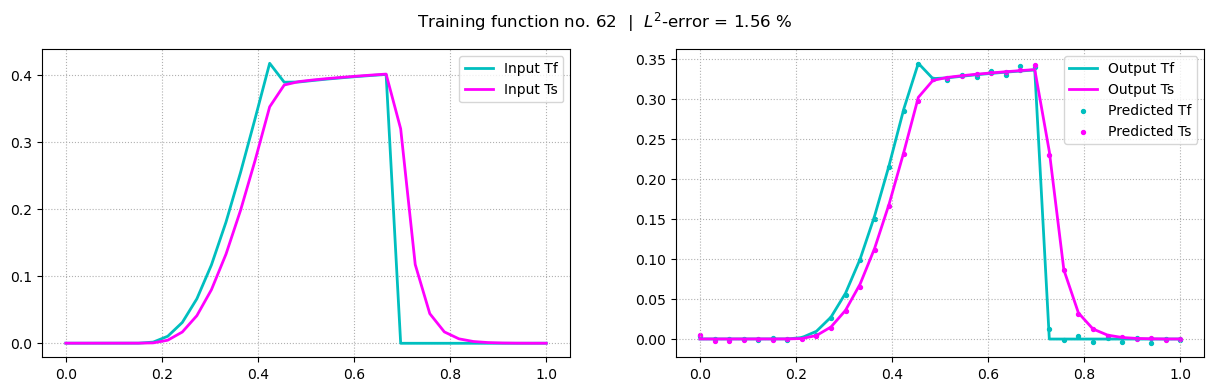

In [12]:
idx_data = 62
input_function_train_n = input_function_train[idx_data, :].unsqueeze(0)
output_function_train_n = output_function_train[idx_data, :].unsqueeze(0)

output_function_train_pred_n = fno(input_function_train_n)

p = 2
err = (torch.mean(abs(output_function_train_n.detach().reshape(-1,) - output_function_train_pred_n.detach().reshape(-1,))**p) /
       torch.mean(abs(output_function_train_n.detach())**p))**(1/p)*100

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax = axes[0]
ax.grid(True, which="both", ls=":")
ax.plot(input_function_train_n[0,:,0].detach(), input_function_train_n[0,:,1].detach(), label="Input Tf", c="c", lw=2)
ax.plot(input_function_train_n[0,:,0].detach(), input_function_train_n[0,:,2].detach(), label="Input Ts", c="magenta", lw=2)
ax.legend()

ax = axes[1]
ax.grid(True, which="both", ls=":")
ax.plot(input_function_train_n[0,:,0].detach(), output_function_train_n[0,:,0].detach(), label="Output Tf", c="c", lw=2)
ax.plot(input_function_train_n[0,:,0].detach(), output_function_train_n[0,:,1].detach(), label="Output Ts", c="magenta", lw=2)
ax.scatter(input_function_train_n[0,:,0].detach(), output_function_train_pred_n[0,:,0].detach(), label="Predicted Tf", s=8, c="c")
ax.scatter(input_function_train_n[0,:,0].detach(), output_function_train_pred_n[0,:,1].detach(), label="Predicted Ts", s=8, c="magenta")
ax.legend()

fig.suptitle("Training function no. {:d}  |  $L^2$-error = {:.2f} %".format(idx_data, err.item()))

plt.show()

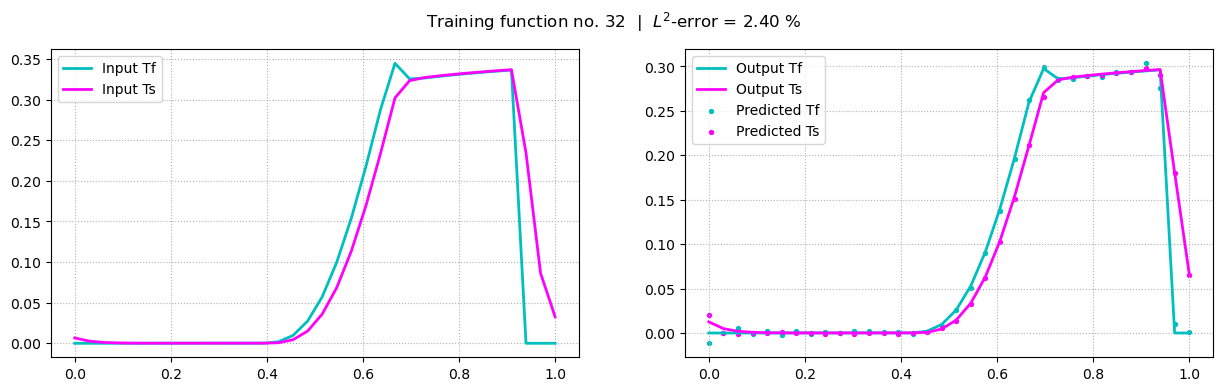

In [13]:
idx_data = 32
input_function_test_n = input_function_test[idx_data, :].unsqueeze(0)
output_function_test_n = output_function_test[idx_data, :].unsqueeze(0)

output_function_test_pred_n = fno(input_function_test_n)

p = 2
err = (torch.mean(abs(output_function_test_n.detach().reshape(-1,) - output_function_test_pred_n.detach().reshape(-1,))**p) /
       torch.mean(abs(output_function_test_n.detach())**p))**(1/p)*100
# print("Relative L{:d} error: {:.2f} %".format(p, err.item()))


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax = axes[0]
ax.grid(True, which="both", ls=":")
ax.plot(input_function_test_n[0,:,0].detach(), input_function_test_n[0,:,1].detach(), label="Input Tf", c="c", lw=2)
ax.plot(input_function_test_n[0,:,0].detach(), input_function_test_n[0,:,2].detach(), label="Input Ts", c="magenta", lw=2)
ax.legend()

ax = axes[1]
ax.grid(True, which="both", ls=":")
ax.plot(input_function_test_n[0,:,0].detach(), output_function_test_n[0,:,0].detach(), label="Output Tf", c="c", lw=2)
ax.plot(input_function_test_n[0,:,0].detach(), output_function_test_n[0,:,1].detach(), label="Output Ts", c="magenta", lw=2)
ax.scatter(input_function_test_n[0,:,0].detach(), output_function_test_pred_n[0,:,0].detach(), label="Predicted Tf", s=8, c="c")
ax.scatter(input_function_test_n[0,:,0].detach(), output_function_test_pred_n[0,:,1].detach(), label="Predicted Ts", s=8, c="magenta")
ax.legend()

fig.suptitle("Training function no. {:d}  |  $L^2$-error = {:.2f} %".format(idx_data, err.item()))

plt.show()

### Prediction

In [18]:
idx_batch, idx_pos

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
        dtype=torch.int32),
 tensor([33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16,
         15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0],
        dtype=torch.int32))

In [19]:
dt = tseries["t"][1] - tseries["t"][0]
ensemble_idx = list(range(tseries.shape[0] - 68 + 1, tseries.shape[0] - 34 + 1))
# ensemble_idx = list(range(tseries.shape[0] - 34, tseries.shape[0] - 33))
input_series = np.array([tseries.iloc[idx_start:idx_start+34, :] for idx_start in ensemble_idx])
input_series = torch.from_numpy(input_series).type(torch.float32)
input_series[:, :, 0] = (input_series[:, :, 0].T - input_series[:, 0, 0]).T/t_len
input_series[:, :, 1:] = normalize_therm(input_series[:, :, 1:])

fno.eval()
output_series = fno(input_series)

predicted_t = np.zeros((34, 2))
for idx_pred in range(34):
    idx_batch = torch.arange(idx_pred, 34, dtype=torch.int64)
    idx_pos = 34 + idx_pred - 1 - idx_batch
    predicted_t[idx_pred, :] = output_series[idx_batch, idx_pos, :].mean(dim=0).squeeze().detach().cpu().numpy()

pred_ds = pd.read_csv(os.path.join(base_path, "TestingData.txt"), header=0)
pred_ds["tf0"] = denormalize_therm(predicted_t[:, 0])
pred_ds["ts0"] = denormalize_therm(predicted_t[:, 1])

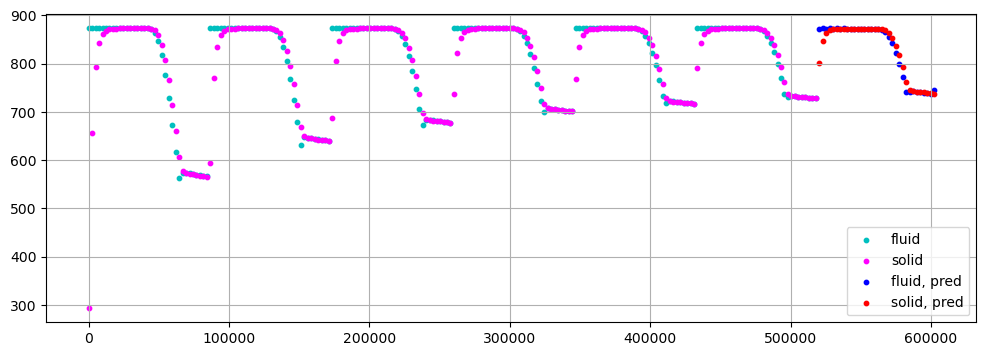

In [29]:
pred_ds = pd.read_csv(os.path.join(base_path, "Task3_m17.txt"), header=0)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

ax = axes
ax.scatter(tseries["t"], tseries["tf0"], s=10, color='c', label="fluid")
ax.scatter(tseries["t"], tseries["ts0"], s=10, color='magenta', label="solid")
ax.scatter(pred_ds["t"], pred_ds["tf0"], s=10, color='b', label="fluid, pred")
ax.scatter(pred_ds["t"], pred_ds["ts0"], s=10, color='r', label="solid, pred")
ax.legend()
ax.grid()

plt.show()

In [ ]:
output_series[idx_batch, idx_pos, :].mean(dim=0)

tensor([0.7897, 0.7770], grad_fn=<MeanBackward1>)